In [1]:
# Parameters
EXP_NUM = "default"

In [2]:
# Parameters
EXP_NUM = "exp121"


# 2023 1st place solution
[kaggle notebook](https://www.kaggle.com/code/rustyb/paris-madness-2023#Load-the-data!)

# コードの流れ
1. hydraからハイパラ取得し、パスなどを設定

    regular&tourney Detaile Result, Seedを使用し、tourneyを目的変数としてモデルを予測していく

    regular_data->season_statistics->

    以下の前処理をする

2. データ２倍にかさまし
3. regularに対して特徴量の追加
    各チームごとに加えるもの
   - EFFG: フィールドゴール成功率
   - EFFG3: フィールドゴール3p成功率
   - DARE: フィールドゴールにおける3P率
   - "win"を目的変数とする(Team, Season)のロジスティック回帰した各係数
    対戦カードごとに加える特徴量
    - PointDiff: ポイント差
    - win: 1 if PointDiff>0 else 0
4. (Team, Season)ごとに特徴量season_statixtics追加
    - win_ratio_14d
    - box score mean
    - quality
    - seed
5. season_average.enabled=trueなら直近３シーズンの加重平均の処理加える
6. tourneyをteamID, Season, score(y)のみ取り出してこれに対してseason_statisticsの結合と特徴量微調整
   - seed->seeddiff
   - fillna()

7. モデル構築
8. KFOLD->OOF予測->spline曲線求めてlogloss算出
    - KFOLDによる交差検証（CV）
        repeat_cv 回のループで、各反復ごとにKFold（folds_splits個）によりデータを分割し、XGBoostのCVを実行しています。
        各foldでの結果（例えば、訓練MAE、検証MAEの平均値や標準偏差）がcv_resultとして得られ、それをxgb_cvリストに格納します。
        この段階で重要なのは、各反復での検証用MAEの平均値 (test-mae-mean) の最小値と、そのときのブーストラウンド数です。
        それらは後で、最適なイテレーション数 (iteration_counts) として計算され、val_mae にも格納されます。
    - OOF予測の流れ

        各反復ごとに、新たなKFoldを用いてデータを分割。
        各foldごとに、学習データでモデルを訓練し、検証データに対して予測を実施。
        すべてのfold分の予測結果を1つの予測配列にまとめ、最後に -30～30 の範囲にクリップしています。
        重要な結果

        OOF予測結果（oof_preds）自体は後段で別途評価指標に使用できるほか、各反復ごとの予測精度や誤差を算出する際の基礎データ
9.  提出フェーズ
    - 最適paramで全データ使って訓練
    - 提出試合の予測

memo

欠損値が発生していいのか検討して保管について考える
seedがかけているのはregularに対してseedを与えているから大丈夫。最終的なtourneyには欠損０で追加できているから問題ない

In [3]:

import os
import sys
from pathlib import Path
import collections
from datetime import datetime
import shutil
import yaml
from tqdm import tqdm
import time
import optuna
from loguru import logger
import collections

from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import UnivariateSpline

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.calibration import calibration_curve
from sklearn.metrics import log_loss,mean_squared_error, mean_absolute_error, roc_auc_score, average_precision_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.isotonic import IsotonicRegression

import statsmodels.api as sm

START_TIME = time.time()


#####
#EXP_NUM = "exp121"
#####
print(EXP_NUM)

# hydraの初期設定と指定ハイパラの取得
sys.path.append(os.path.abspath("/workspace"))
sys.path.append("C:\\Users\\81809\\Documents\\ALL_CODE\\kaggle\\March Machine Learning Mania 2025")
with initialize_config_module(version_base=None, config_module="conf"):
    cfg = compose(
        config_name="base.yaml",
        overrides=[
            f"+exp={EXP_NUM}" #defaultexp001->exp002のオーバーライド
        ],
    )
    
    OmegaConf.resolve(cfg)
    print("Omega conf is below")
    print(OmegaConf.to_yaml(cfg))


C:\Users\81809\anaconda3\envs\deep_learning_pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


exp121
Omega conf is below
dir:
  input_dir: ../input
  output_dir: ../output
  src_path: ../src
  conf_path: ../conf
exp:
  name: feature_engineering_9
  print_name: 'best model (3/18) & FGA ->FGAmean '
  tournament:
    use_start_season: 1985
    target_season: 2019
  features:
    cal_mean_boxscore:
      T1_Score: true
      T2_Score: true
      PointDiff: true
      T1_FGA: true
      T2_FGA: true
      T1_FTA: false
      T2_FTA: false
      T1_FGA3: false
      T2_FGA3: false
      T1_FGM: true
      T2_FGM: true
      T1_FGM3: false
      T2_FGM3: false
      T1_FTM: false
      T2_FTM: false
      T1_EFFG: false
      T2_EFFG: false
      T1_EFFG3: false
      T2_EFFG3: false
      T1_EFG_SUM: true
      T2_EFG_SUM: true
      T1_TO_RATIO: true
      T2_TO_RATIO: true
      T1_OR: true
      T2_OR: true
      T1_DR: true
      T2_DR: true
      T1_REB_RATE: true
      T2_REB_RATE: true
      T1_FT_RATE: true
      T2_FT_RATE: true
      T1_RATING: false
      T2_RATING: false


In [4]:
PREDICT_YEAR = cfg.exp.tournament.target_season
name = f"{cfg.exp.name}"
now = str(datetime.now())
print("########")
print(f"output dir name: {name}")
print(f"Run on {now}")
print(cfg.exp.print_name)
print("########")

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
CONF_PATH = os.path.join(BASE_DIR, "conf")
INPUT_PATH = os.path.join(BASE_DIR, "input")
EXP_PATH = os.path.join(CONF_PATH, "exp", f"{EXP_NUM}.yaml")
OUTPUT_PATH = os.path.join(BASE_DIR, "output", name)
SRC_PATH = cfg.dir.src_path
sys.path.append(SRC_PATH)

os.makedirs(OUTPUT_PATH, exist_ok=True)  
with open(EXP_PATH, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)
shutil.copyfile(EXP_PATH, os.path.join(OUTPUT_PATH, f"{EXP_NUM}.yaml"))


y_season = cfg.exp.tournament.target_season
FEATURES = cfg.exp.features
MODEL = cfg.exp.model
results = ["", f"-----{PREDICT_YEAR}-----", now ,name, cfg.exp.print_name,""]

########
output dir name: feature_engineering_9
Run on 2025-03-18 17:03:09.537856
best model (3/18) & FGA ->FGAmean 
########


In [5]:
tourney_results = pd.concat([
    pd.read_csv(os.path.join(INPUT_PATH,"MNCAATourneyDetailedResults.csv")),
    pd.read_csv(os.path.join(INPUT_PATH,"WNCAATourneyDetailedResults.csv")),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv(os.path.join(INPUT_PATH,"MNCAATourneySeeds.csv")),
    pd.read_csv(os.path.join(INPUT_PATH,"WNCAATourneySeeds.csv")),
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv(os.path.join(INPUT_PATH, "MRegularSeasonDetailedResults.csv")),
    pd.read_csv(os.path.join(INPUT_PATH,"WRegularSeasonDetailedResults.csv")),
], ignore_index=True)

ordinal_rank = pd.read_csv(os.path.join(INPUT_PATH, "MMasseyOrdinals.csv"))

# 1試合情報からWin,Lose反転させてデータ数２倍にかさまし and WLoc -> location(0 or -1 or 1)
def prepare_data(df1):
    df = df1.copy()
    ### add new box score
    #type1: normal EFG
    df['WEFFG'] = df['WFGM'] / df['WFGA']
    df['LEFFG'] = df['LFGM'] / df['LFGA']
    #type2: 1stfeature EFG
    df['WEFFG3'] = np.where(df['WFGA3'] == 0, 0, df['WFGM3'] / df['WFGA3'])
    df['LEFFG3'] = np.where(df['LFGA3'] == 0, 0, df['LFGM3'] / df['LFGA3'])
    df['WDARE'] = df['WFGM3'] / df['WFGM']
    df['LDARE'] = df['LFGM3'] / df['LFGM']
    df['WTOQUETOQUE'] = df['WAst'] / df['WFGM']
    df['LTOQUETOQUE'] = df['LAst'] / df['LFGM']
    #type3: OFF/DEF FGE
    df["WEFG_SUM"] = (df["WFGM"]+0.5*df["WFGM3"])/df["WFGA"]
    df["LEFG_SUM"] = (df["LFGM"]+0.5*df["LFGM3"])/df["LFGA"]

    #POSS RATE
    df["WPOSS"] = df["WFGA"] + 0.44*df["WFTA"] - df["WOR"] + df["WTO"]
    df["LPOSS"] = df["LFGA"] + 0.44*df["LFTA"] - df["LOR"] + df["LTO"]
    df["WPOSS_RATE"] = df["WPOSS"]/(df["WPOSS"]+df["LPOSS"])
    df["LPOSS_RATE"] = df["LPOSS"]/(df["WPOSS"]+df["LPOSS"])
    
    #TO Ratio 
    df["WTO_RATIO"] = df["WTO"]/(df["WFGA"]+0.44*df["WFTA"]+df["WTO"])#POSS RATEと違ってOR入っていない
    df["LTO_RATIO"] = df["LTO"]/(df["LFGA"]+0.44*df["LFTA"]+df["LTO"])
    
    # REB%
    df["WREB_RATE"] = df["WOR"]/(df["WOR"]+df["LDR"])
    df["LREB_RATE"] = df["LOR"]/(df["LOR"]+df["WDR"])
    
    #FT %
    df["WFT_RATE"] = df["WFTA"]/df["WFGA"]
    df["LFT_RATE"] = df["LFTA"]/df["LFGA"]
    
    #rating
    df["WRATING"] = df["WScore"]/df["WPOSS"]
    df["LRATING"] = df["LScore"]/df["LPOSS"]
    
        
    #0除算補完
    print(df.info())
        
    #かさましに伴う反転カラム
    dfswap = df.copy()
    # Home, Away変換して反転
    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
    #反転
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]
    output = pd.concat([df, dfswap]).reset_index(drop=True)
    
    
    #add new feature
    #locationを数値に変換
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    #add PointDiff&win
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    output["win"] = np.where(output['PointDiff']>0,1,0)
    
    
    print(f"feature cols after prepare()")
    print(output.columns)
    return output



In [6]:
import numpy as np

# 異常値のチェック
def check_abnormal_values(df):
    print("各カラムの異常値の個数を表示します。\n")

    for col in df.columns:
        nan_count = df[col].isna().sum()  # NaN の数
        inf_count = (df[col] == np.inf).sum()  # inf の数
        neg_inf_count = (df[col] == -np.inf).sum()  # -inf の数

        if nan_count > 0 or inf_count > 0 or neg_inf_count > 0:
            print(f"Column: {col}")
            print(f"  NaN    : {nan_count}")
            print(f"  Inf    : {inf_count}")
            print(f"  -Inf   : {neg_inf_count}")
            print("-" * 30)

# 関数を実行
check_abnormal_values(regular_results)


各カラムの異常値の個数を表示します。



In [7]:
#予測する年以降の情報はフィルタリング
USE_START_YEAR = cfg.exp.tournament.use_start_season
notexist = tourney_results[tourney_results["Season"] == PREDICT_YEAR]
tourney_results = tourney_results[(tourney_results["Season"] >= USE_START_YEAR) & (tourney_results["Season"] < PREDICT_YEAR)]
seeds = seeds[(seeds["Season"] >= USE_START_YEAR) & (seeds["Season"] <= PREDICT_YEAR)]
regular_results = regular_results[(regular_results["Season"] >= USE_START_YEAR) & (regular_results["Season"] <= PREDICT_YEAR)]

regular_data = prepare_data(regular_results)
display(regular_data.head(), regular_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 139193 entries, 0 to 170570
Data columns (total 56 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Season       139193 non-null  int64  
 1   DayNum       139193 non-null  int64  
 2   WTeamID      139193 non-null  int64  
 3   WScore       139193 non-null  int64  
 4   LTeamID      139193 non-null  int64  
 5   LScore       139193 non-null  int64  
 6   WLoc         139193 non-null  object 
 7   NumOT        139193 non-null  int64  
 8   WFGM         139193 non-null  int64  
 9   WFGA         139193 non-null  int64  
 10  WFGM3        139193 non-null  int64  
 11  WFGA3        139193 non-null  int64  
 12  WFTM         139193 non-null  int64  
 13  WFTA         139193 non-null  int64  
 14  WOR          139193 non-null  int64  
 15  WDR          139193 non-null  int64  
 16  WAst         139193 non-null  int64  
 17  WTO          139193 non-null  int64  
 18  WStl         139193 non-null 

feature cols after prepare()
Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'T1_EFFG', 'T2_EFFG', 'T1_EFFG3', 'T2_EFFG3', 'T1_DARE', 'T2_DARE',
       'T1_TOQUETOQUE', 'T2_TOQUETOQUE', 'T1_EFG_SUM', 'T2_EFG_SUM', 'T1_POSS',
       'T2_POSS', 'T1_POSS_RATE', 'T2_POSS_RATE', 'T1_TO_RATIO', 'T2_TO_RATIO',
       'T1_REB_RATE', 'T2_REB_RATE', 'T1_FT_RATE', 'T2_FT_RATE', 'T1_RATING',
       'T2_RATING', 'PointDiff', 'win'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278386 entries, 0 to 278385
Data columns (total 58 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Season 

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T1_TO_RATIO,T2_TO_RATIO,T1_REB_RATE,T2_REB_RATE,T1_FT_RATE,T2_FT_RATE,T1_RATING,T2_RATING,PointDiff,win
0,2003,10,1104,68,1328,62,0,0,27,58,...,0.258659,0.223104,0.388889,0.294118,0.310345,0.415094,0.907635,0.877193,6,1
1,2003,10,1272,70,1393,63,0,0,26,62,...,0.155950,0.136674,0.375000,0.416667,0.306452,0.298507,1.023991,0.929204,7,1
2,2003,11,1266,73,1437,61,0,0,24,58,...,0.123824,0.126156,0.435897,0.543860,0.500000,0.315068,1.144918,0.951341,12,1
3,2003,11,1296,56,1457,50,0,0,18,38,...,0.188561,0.254692,0.230769,0.472222,0.815789,0.306122,0.971548,0.868056,6,1
4,2003,11,1400,77,1208,71,0,0,30,61,...,0.173439,0.119218,0.531250,0.488372,0.213115,0.435484,1.208412,1.129135,6,1


None

In [8]:
#使用特徴量(boxscore_cols)を取得してそれに対して("Season", 'T1_TeamID')でまとめた特徴量の追加
#### 1. win_ration_14d ####
def add_win_ratio_14d(df):
    df_filtered = df[df['DayNum'] > 118].copy()
    df_filtered['Win'] = (df_filtered['PointDiff'] > 0).astype(int)
    
    win_ratio_t1 = df_filtered.groupby(['Season', 'T1_TeamID'])['Win'].mean().reset_index()
    win_ratio_t1.rename(columns={'Win': 'T1_win_ratio_14d'}, inplace=True)
    
    win_ratio_t2 = df_filtered.groupby(['Season', 'T2_TeamID'])['Win'].mean().reset_index()
    win_ratio_t2.rename(columns={'Win': 'T2_win_ratio_14d'}, inplace=True)
    
    df = df.merge(win_ratio_t1, on=['Season', 'T1_TeamID'], how='left')
    df = df.merge(win_ratio_t2, on=['Season', 'T2_TeamID'], how='left')
    
    return df

##### 2. add mean of boxscore ####
def make_col_avg(df, boxscore, group = ["Season", "T1_TeamID"], func= [np.mean]):
    df_stat = df.groupby(group)[boxscore].agg(func)
    df_stat.columns = [''.join(col).strip() for col in df_stat.columns.values]
    df_stat = df_stat.reset_index()

    win_ratio_cols = ['T1_win_ratio_14d'] #ここマージの関係からT2_win_ratio_14dを外したけど大丈夫か考える
    df_win_ratio = df[group + win_ratio_cols].drop_duplicates()
    df_stat = df_stat.merge(df_win_ratio, on=group, how='left')
    
    return df_stat

#### 3. add team quality ####
# 3.0 ロジスティックを行うためのregular_season_effectsデータフレームの作成
def make_regular_season_effects(df):
    regular_season_effects = df[['Season', 'T1_TeamID', 'T2_TeamID', 'PointDiff']].copy()
    regular_season_effects['win'] = np.where(regular_season_effects['PointDiff'] > 0, 1, 0)
    return regular_season_effects

# 3.1
#各シーズンごとの総当たりに対するロジスティック回帰を行う
#目的変数はfeatureenginneringから作成したPointDiffの正負に依存するWinとする.
#新たな特徴量"quarity"をseasonごとの戦績をもとにロジスティックの回帰係数として導入している
def team_quality(season,df):
    season_data = df[df["Season"] == season]
    X = season_data[['T1_TeamID', 'T2_TeamID']]
    y = season_data['win']
    print(X.shape, y.shape)
    encoder = OneHotEncoder(sparse_output=False) #多重共線性防止, 密行列指定
    X_encoded = encoder.fit_transform(X)
    
    model = LogisticRegression(fit_intercept=False)
    model.fit(X_encoded, y)
    team_ids = encoder.get_feature_names_out(['T1_TeamID', 'T2_TeamID'])

    
    #quarity: (チーム数)*2(ID, 回帰係数)
    quality = pd.DataFrame({
        'TeamID': team_ids,
        'quality': model.coef_.flatten() #T1_TeamID_1112,,,の形でチーム数分の回帰係数が入る
    })

    # 値をint 1112 のように整形
    quality = quality[quality['TeamID'].str.contains('T1_TeamID')]
    quality['TeamID'] = quality['TeamID'].str.replace('T1_TeamID_', '', regex=True).astype(int)
    quality['Season'] = season

    #display(quality.head())
    print(f"fin make {season}'s team quarity")
    return quality

# 4. add seed
def add_seed(df, seeds):
    temp = seeds.copy()
    temp['Seed'] = temp['Seed'].apply(lambda x: int(x[1:3]))
    temp.columns = ['Season','T1_seed','T1_TeamID']
    df = pd.merge(df, temp, on=["Season", "T1_TeamID"], how="left")
    return df 

# 5. add Ordinal rank
def add_ordinalrank(df, ordinal):
    df_rank = ordinal.groupby(["Season", "TeamID"])["OrdinalRank"].agg(np.mean).reset_index()
    df_rank.head()
    ranks = df_rank.rename(columns={'TeamID': 'T1_TeamID', 'OrdinalRank': 'T1_OrdinalRank'})
    df = pd.merge(df,ranks,on = ["Season","T1_TeamID"],how = "left")
    return df

# main 
def make_season_statistics(df, boxscore, seeds, func = [np.mean]):
    # 1. Win Ratio の計算と追加
    add_win = add_win_ratio_14d(df)
    print("after add win ratio")
    print(add_win.columns)  
    
    #2. 
    add_mean = make_col_avg(add_win, boxscore)
    print("after mean of boxscore")
    print(add_mean.columns)
    
    #3. 
    global PREDICT_YEAR, USE_START_YEAR
    start_season = max(FEATURES.start_quality_season, USE_START_YEAR)
    print(f"use season for quality feature is: {start_season}")
    regular_season_effects = make_regular_season_effects(df)
    glm_season = [i for i in range(start_season, PREDICT_YEAR+1)]

    if 2020 in glm_season:
        glm_season.remove(2020)
    glm_quality = pd.concat([team_quality(season, regular_season_effects) for season in glm_season]).reset_index(drop=True)
    # add glm quality 
    glm_quality_T1 = glm_quality.rename(columns={'TeamID': 'T1_TeamID', 'quality': 'T1_quality'})
    add_glm = add_mean.merge(glm_quality_T1, on=['Season', 'T1_TeamID'], how='left')

    print("add glm quality")
    print(add_glm.columns)
    
    #4. 
    add_seeds = add_seed(add_glm, seeds)
    print("add seeds (final form)")
    print(add_seeds.columns)
    
    #5. 
    add_rank = add_ordinalrank(add_seeds, ordinal_rank)
    print("add ordinal rank")
    print(add_rank.columns)  
    return add_rank

In [9]:
features = FEATURES.cal_mean_boxscore
boxscore_cols = [col for col, use in features.items() if use]
print("use boxscore col is")
print(boxscore_cols)

season_statistics = make_season_statistics(regular_data, boxscore_cols, seeds, func = [np.mean])
season_statistics.tail()

use boxscore col is
['T1_Score', 'T2_Score', 'PointDiff', 'T1_FGA', 'T2_FGA', 'T1_FGM', 'T2_FGM', 'T1_EFG_SUM', 'T2_EFG_SUM', 'T1_TO_RATIO', 'T2_TO_RATIO', 'T1_OR', 'T2_OR', 'T1_DR', 'T2_DR', 'T1_REB_RATE', 'T2_REB_RATE', 'T1_FT_RATE', 'T2_FT_RATE', 'T1_POSS_RATE', 'T2_POSS_RATE', 'T1_Ast', 'T2_Ast', 'T1_TO', 'T2_TO', 'T1_Stl', 'T2_Stl', 'T1_Blk', 'T2_Blk', 'T1_PF', 'T2_PF']


after add win ratio
Index(['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score',
       'location', 'NumOT', 'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM',
       'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk',
       'T1_PF', 'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA',
       'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF',
       'T1_EFFG', 'T2_EFFG', 'T1_EFFG3', 'T2_EFFG3', 'T1_DARE', 'T2_DARE',
       'T1_TOQUETOQUE', 'T2_TOQUETOQUE', 'T1_EFG_SUM', 'T2_EFG_SUM', 'T1_POSS',
       'T2_POSS', 'T1_POSS_RATE', 'T2_POSS_RATE', 'T1_TO_RATIO', 'T2_TO_RATIO',
       'T1_REB_RATE', 'T2_REB_RATE', 'T1_FT_RATE', 'T2_FT_RATE', 'T1_RATING',
       'T2_RATING', 'PointDiff', 'win', 'T1_win_ratio_14d',
       'T2_win_ratio_14d'],
      dtype='object')
after mean of boxscore
Index(['Season', 'T1_TeamID', 'T1_Scoremean', 'T2_Scoremean', 'PointDiffmean',
       'T1_FGAmean', 'T2_FGAmean', 'T1_FGMmean', 'T2_FGMmean',
       'T1

C:\Users\81809\AppData\Local\Temp\ipykernel_11780\386782032.py:20: FutureWarning: The provided callable <function mean at 0x00000295AD6E6520> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_stat = df.groupby(group)[boxscore].agg(func)


fin make 2003's team quarity
(9142, 2) (9142,)
fin make 2004's team quarity
(9350, 2) (9350,)
fin make 2005's team quarity
(9514, 2) (9514,)
fin make 2006's team quarity
(10086, 2) (10086,)


fin make 2007's team quarity
(10326, 2) (10326,)
fin make 2008's team quarity
(10498, 2) (10498,)
fin make 2009's team quarity
(20600, 2) (20600,)


fin make 2010's team quarity
(20660, 2) (20660,)
fin make 2011's team quarity
(20606, 2) (20606,)


fin make 2012's team quarity
(21008, 2) (21008,)


fin make 2013's team quarity
(21228, 2) (21228,)


fin make 2014's team quarity
(21136, 2) (21136,)
fin make 2015's team quarity
(21156, 2) (21156,)


fin make 2016's team quarity
(21210, 2) (21210,)


fin make 2017's team quarity
(21228, 2) (21228,)


fin make 2018's team quarity
(21406, 2) (21406,)


fin make 2019's team quarity
add glm quality
Index(['Season', 'T1_TeamID', 'T1_Scoremean', 'T2_Scoremean', 'PointDiffmean',
       'T1_FGAmean', 'T2_FGAmean', 'T1_FGMmean', 'T2_FGMmean',
       'T1_EFG_SUMmean', 'T2_EFG_SUMmean', 'T1_TO_RATIOmean',
       'T2_TO_RATIOmean', 'T1_ORmean', 'T2_ORmean', 'T1_DRmean', 'T2_DRmean',
       'T1_REB_RATEmean', 'T2_REB_RATEmean', 'T1_FT_RATEmean',
       'T2_FT_RATEmean', 'T1_POSS_RATEmean', 'T2_POSS_RATEmean', 'T1_Astmean',
       'T2_Astmean', 'T1_TOmean', 'T2_TOmean', 'T1_Stlmean', 'T2_Stlmean',
       'T1_Blkmean', 'T2_Blkmean', 'T1_PFmean', 'T2_PFmean',
       'T1_win_ratio_14d', 'T1_quality'],
      dtype='object')
add seeds (final form)
Index(['Season', 'T1_TeamID', 'T1_Scoremean', 'T2_Scoremean', 'PointDiffmean',
       'T1_FGAmean', 'T2_FGAmean', 'T1_FGMmean', 'T2_FGMmean',
       'T1_EFG_SUMmean', 'T2_EFG_SUMmean', 'T1_TO_RATIOmean',
       'T2_TO_RATIOmean', 'T1_ORmean', 'T2_ORmean', 'T1_DRmean', 'T2_DRmean',
       'T1_REB_RATEmean', 

C:\Users\81809\AppData\Local\Temp\ipykernel_11780\386782032.py:79: FutureWarning: The provided callable <function mean at 0x00000295AD6E6520> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_rank = ordinal.groupby(["Season", "TeamID"])["OrdinalRank"].agg(np.mean).reset_index()


add ordinal rank
Index(['Season', 'T1_TeamID', 'T1_Scoremean', 'T2_Scoremean', 'PointDiffmean',
       'T1_FGAmean', 'T2_FGAmean', 'T1_FGMmean', 'T2_FGMmean',
       'T1_EFG_SUMmean', 'T2_EFG_SUMmean', 'T1_TO_RATIOmean',
       'T2_TO_RATIOmean', 'T1_ORmean', 'T2_ORmean', 'T1_DRmean', 'T2_DRmean',
       'T1_REB_RATEmean', 'T2_REB_RATEmean', 'T1_FT_RATEmean',
       'T2_FT_RATEmean', 'T1_POSS_RATEmean', 'T2_POSS_RATEmean', 'T1_Astmean',
       'T2_Astmean', 'T1_TOmean', 'T2_TOmean', 'T1_Stlmean', 'T2_Stlmean',
       'T1_Blkmean', 'T2_Blkmean', 'T1_PFmean', 'T2_PFmean',
       'T1_win_ratio_14d', 'T1_quality', 'T1_seed', 'T1_OrdinalRank'],
      dtype='object')


,Season,T1_TeamID,T1_Scoremean,T2_Scoremean,PointDiffmean,T1_FGAmean,T2_FGAmean,T1_FGMmean,T2_FGMmean,T1_EFG_SUMmean,...,T1_Stlmean,T2_Stlmean,T1_Blkmean,T2_Blkmean,T1_PFmean,T2_PFmean,T1_win_ratio_14d,T1_quality,T1_seed,T1_OrdinalRank
9298,2019,3462,60.862069,66.482759,-5.620690,57.517241,59.758621,21.896552,24.448276,0.448019,...,7.586207,7.758621,2.586207,3.172414,15.241379,15.172414,0.0,-0.296941,NaN,NaN
9299,2019,3463,63.344828,61.551724,1.793103,60.517241,60.379310,23.724138,21.965517,0.438814,...,5.172414,8.344828,3.586207,2.517241,16.448276,17.551724,0.0,0.134368,NaN,NaN
9300,2019,3464,68.137931,58.000000,10.137931,55.758621,58.655172,23.241379,21.862069,0.494845,...,4.344828,7.448276,3.482759,3.482759,13.862069,17.896552,0.5,0.638405,NaN,NaN
9301,2019,3465,76.200000,69.840000,6.360000,67.520000,69.200000,28.560000,26.600000,0.493625,...,7.280000,7.920000,3.160000,3.160000,15.520000,15.440000,0.5,-0.182555,NaN,NaN
9302,2019,3466,69.521739,63.217391,6.304348,58.434783,58.260870,24.869565,23.913043,0.478102,...,8.478261,8.478261,3.695652,3.217391,17.478261,19.173913,0.0,0.107970,NaN,NaN


In [10]:
season_statistics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9303 entries, 0 to 9302
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Season            9303 non-null   int64  
 1   T1_TeamID         9303 non-null   int64  
 2   T1_Scoremean      9303 non-null   float64
 3   T2_Scoremean      9303 non-null   float64
 4   PointDiffmean     9303 non-null   float64
 5   T1_FGAmean        9303 non-null   float64
 6   T2_FGAmean        9303 non-null   float64
 7   T1_FGMmean        9303 non-null   float64
 8   T2_FGMmean        9303 non-null   float64
 9   T1_EFG_SUMmean    9303 non-null   float64
 10  T2_EFG_SUMmean    9303 non-null   float64
 11  T1_TO_RATIOmean   9303 non-null   float64
 12  T2_TO_RATIOmean   9303 non-null   float64
 13  T1_ORmean         9303 non-null   float64
 14  T2_ORmean         9303 non-null   float64
 15  T1_DRmean         9303 non-null   float64
 16  T2_DRmean         9303 non-null   float64


In [11]:
####ボックスscoreの平均に対して、過去３年の加重平均を取るときの処理 ####
def get_mean_of_3_season(val_2ps, val_1ps, val_0ps, 
                         weight_2, weight_1, weight_0, 
                         degree_weight=1.0
                         ):
    weight_2 = weight_2**degree_weight
    weight_1 = weight_1**degree_weight
    weight_0 = weight_0**degree_weight
    if val_2ps == 0  and val_1ps == 0:
        return val_0ps
    elif val_2ps == 0:
        return (val_1ps*weight_2 + val_0ps*weight_1)/(weight_2 + weight_1)
    else:
        sum_of_values = val_2ps*weight_2 + val_1ps*weight_1 + val_0ps*weight_0
        return sum_of_values/(weight_2 + weight_1 + weight_0)

def get_3_feature(df_team, feature):
    value_2_seasons_ago = 0
    value_1_season_ago = 0
    value_0_season_ago = 0
    for _, val in df_team.iterrows():
        value_2_seasons_ago = value_1_season_ago
        value_1_season_ago = value_0_season_ago
        value_0_season_ago = val[feature]
    return value_2_seasons_ago, value_1_season_ago, value_0_season_ago

def write_mean_of_3_seasons(df, features, weight, degree_weight=1.0):
    """
    val_0ps - current season value
    weight_0 - current season weight
    val_1ps - last season value
    val_2ps - the value of the season before last
    """
    weight_2=weight[0]
    weight_1=weight[1]
    weight_0=weight[2]
    df_copy = df.copy()
    suffix = "_mn3s"
    
    for ft in features:
        df_copy[ft + suffix] = 0
    for idx, val in tqdm(df_copy.iterrows(), total=len(df_copy)):
        team = val.T1_TeamID
        season = val.Season
        df_team = df_copy[(df_copy.T1_TeamID == team)&
                          (df_copy.Season <= season)&
                          (df_copy.Season > season-3)]
        for ft in features:
            val_2ps, val_1ps, val_0ps = get_3_feature(df_team, ft)
            ft_mean_3 = get_mean_of_3_season(val_2ps, val_1ps, val_0ps, weight_2, weight_1, weight_0, degree_weight=degree_weight)
            df_copy.loc[idx, ft + suffix] = ft_mean_3
    return df_copy

In [12]:
flag_3season_avg = FEATURES.season_average.enabled

#trueのときの処理理解してfalseと一致させる
if flag_3season_avg:
    print("#####")
    print("use 3 season average")
    print("#####")
    weight = FEATURES.season_average.weights
    years = FEATURES.season_average.past_years
    assert years==len(weight)
    
    features_for_calc = ["T1_Scoremean", "T1_FGAmean",  "T1_FGA3mean"]
    season_statistics_with_3_seas = write_mean_of_3_seasons(
        season_statistics, features_for_calc, weight, degree_weight=1.0
    )
    
    season_statistics_T1 = season_statistics_with_3_seas.copy()
    season_statistics_T2 = season_statistics_with_3_seas.copy()
    
else:
    print("#####")
    print("skip 3 season verage")
    print("#####")
    season_statistics_T1 = season_statistics.copy()
    season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"


season_statistics_T2.rename(columns = {
    "T1_TeamID": "T2_TeamID"
}, inplace=True)
display(season_statistics_T1.head(2), season_statistics_T2.tail(2))

#####
skip 3 season verage
#####


,Season,T1_TeamID,T1_Scoremean,T1_opponent_Scoremean,T1_PointDiffmean,T1_FGAmean,T1_opponent_FGAmean,T1_FGMmean,T1_opponent_FGMmean,T1_EFG_SUMmean,...,T1_Stlmean,T1_opponent_Stlmean,T1_Blkmean,T1_opponent_Blkmean,T1_PFmean,T1_opponent_PFmean,T1_win_ratio_14d,T1_quality,T1_seed,T1_OrdinalRank
0,2003,1102,57.250000,57.000000,0.25000,39.785714,42.428571,19.142857,19.285714,0.584407,...,5.964286,5.428571,1.785714,1.571429,18.750000,18.357143,0.333333,-0.070776,NaN,144.2875
1,2003,1103,78.777778,78.148148,0.62963,55.851852,57.000000,27.148148,27.777778,0.536564,...,7.259259,6.407407,2.333333,2.851852,19.851852,22.444444,0.333333,-0.116192,NaN,182.2050


,Season,T2_TeamID,T2_Scoremean,T2_opponent_Scoremean,T2_PointDiffmean,T2_FGAmean,T2_opponent_FGAmean,T2_FGMmean,T2_opponent_FGMmean,T2_EFG_SUMmean,...,T2_Stlmean,T2_opponent_Stlmean,T2_Blkmean,T2_opponent_Blkmean,T2_PFmean,T2_opponent_PFmean,T2_win_ratio_14d,T2_quality,T2_seed,T2_OrdinalRank
9301,2019,3465,76.200000,69.840000,6.360000,67.520000,69.20000,28.560000,26.600000,0.493625,...,7.280000,7.920000,3.160000,3.160000,15.520000,15.440000,0.5,-0.182555,NaN,NaN
9302,2019,3466,69.521739,63.217391,6.304348,58.434783,58.26087,24.869565,23.913043,0.478102,...,8.478261,8.478261,3.695652,3.217391,17.478261,19.173913,0.0,0.107970,NaN,NaN


# Toureney dataの処理
1. pointdiff, pointが目的変数となるのでそれはyに分離
2. seasonstatisticを結合したものをXとして作る

In [13]:

def process_tourney(df1, mode="tourney"):
    #Season, teamid ->X, team_score->y
    df = df1.copy()
    if mode=="tourney":
        df = prepare_data(df) 
        y = df["T1_Score"]-df["T2_Score"]
    X = df[['Season', 'T1_TeamID', 'T2_TeamID']]
    X = pd.merge(X, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
    X = pd.merge(X, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')
    
    #seed->seed diff
    X["seed_diff"] = X["T1_seed"] - X["T2_seed"]
    #rank->rank diff
    X["rank_diff"] = X["T1_OrdinalRank"] - X["T2_OrdinalRank"]
    #quality->quality diff
    X["quality_diff"] = X["T1_quality"] - X["T2_quality"]
    #win_ratio_14d -> win_raio_14d_diff
    X["win_ratio_14d_diff"] = X["T1_win_ratio_14d"] - X["T2_win_ratio_14d"]
    #tourney_data.drop(columns=["T1_seed", "T2_seed"], inplace=True)

    X = X.drop(columns=["T1_seed", "T2_seed", "T1_OrdinalRank", "T2_OrdinalRank", 
                        "T1_quality", "T2_quality", "T1_win_ratio_14d", "T2_win_ratio_14d"
                        ])
    
    if FEATURES.T1_FGAdiff: 
        X["T1_FGA_diff"] = X["T1_FGAmean"] - X["T1_opponent_FGAmean"]
        X["T2_FGA_diff"] = X["T2_FGAmean"] - X["T2_opponent_FGAmean"]
        X = X.drop(columns=["T1_FGAmean", "T2_FGAmean", "T1_opponent_FGAmean", "T2_opponent_FGAmean"])
        
    # if rank_diff is False, drop.
    IS_RANKDIFF = FEATURES.rank_diff
    if not IS_RANKDIFF:
        X = X.drop(columns=["rank_diff"])
        print("drop rank_diff")
    
    # if fillna is true-> run fillna()
    FILLNA = FEATURES.fillna.quality
    if FILLNA=="nan":
        print(f"no fillna, use nan")
        X["quality_diff"] = X["quality_diff"].fillna(np.nan)
    else:
        print(f"fillna quality feature for {FILLNA}")
        X["quality_diff"] = X["quality_diff"].fillna(FILLNA)

        
    return X, y if mode=="tourney" else X

In [14]:
X, y = process_tourney(tourney_results)

<class 'pandas.core.frame.DataFrame'>
Index: 1615 entries, 0 to 1948
Data columns (total 56 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Season       1615 non-null   int64  
 1   DayNum       1615 non-null   int64  
 2   WTeamID      1615 non-null   int64  
 3   WScore       1615 non-null   int64  
 4   LTeamID      1615 non-null   int64  
 5   LScore       1615 non-null   int64  
 6   WLoc         1615 non-null   object 
 7   NumOT        1615 non-null   int64  
 8   WFGM         1615 non-null   int64  
 9   WFGA         1615 non-null   int64  
 10  WFGM3        1615 non-null   int64  
 11  WFGA3        1615 non-null   int64  
 12  WFTM         1615 non-null   int64  
 13  WFTA         1615 non-null   int64  
 14  WOR          1615 non-null   int64  
 15  WDR          1615 non-null   int64  
 16  WAst         1615 non-null   int64  
 17  WTO          1615 non-null   int64  
 18  WStl         1615 non-null   int64  
 19  WBlk       

In [15]:
#opponentなど明示的に特徴量選出に基づいて落とす
def drop_columns(df, cols):
    if not cols: return df
    existing_cols = [col for col in cols if col in df.columns]
    print(f"drop col list: {existing_cols}")
    return df.drop(columns=existing_cols)

drop_col = FEATURES.dropfeatures
X = drop_columns(X, drop_col)

drop col list: ['T1_TOmean', 'T2_TOmean', 'T1_opponent_POSS_RATEmean', 'T2_opponent_POSS_RATEmean', 'T1_opponent_Astmean', 'T2_opponent_Astmean', 'T1_opponent_FT_RATEmean', 'T2_opponent_FT_RATEmean', 'T1_opponent_Stlmean', 'T2_opponent_Stlmean', 'T1_ORmean', 'T2_ORmean', 'T1_opponent_ORmean', 'T2_opponent_ORmean', 'T1_TeamID', 'T2_TeamID', 'Season']


In [16]:
print("最終的な X の特徴量")
print(X.columns)

最終的な X の特徴量
Index(['T1_Scoremean', 'T1_opponent_Scoremean', 'T1_PointDiffmean',
       'T1_FGMmean', 'T1_opponent_FGMmean', 'T1_EFG_SUMmean',
       'T1_opponent_EFG_SUMmean', 'T1_TO_RATIOmean',
       'T1_opponent_TO_RATIOmean', 'T1_DRmean', 'T1_opponent_DRmean',
       'T1_REB_RATEmean', 'T1_opponent_REB_RATEmean', 'T1_FT_RATEmean',
       'T1_POSS_RATEmean', 'T1_Astmean', 'T1_opponent_TOmean', 'T1_Stlmean',
       'T1_Blkmean', 'T1_opponent_Blkmean', 'T1_PFmean', 'T1_opponent_PFmean',
       'T2_Scoremean', 'T2_opponent_Scoremean', 'T2_PointDiffmean',
       'T2_FGMmean', 'T2_opponent_FGMmean', 'T2_EFG_SUMmean',
       'T2_opponent_EFG_SUMmean', 'T2_TO_RATIOmean',
       'T2_opponent_TO_RATIOmean', 'T2_DRmean', 'T2_opponent_DRmean',
       'T2_REB_RATEmean', 'T2_opponent_REB_RATEmean', 'T2_FT_RATEmean',
       'T2_POSS_RATEmean', 'T2_Astmean', 'T2_opponent_TOmean', 'T2_Stlmean',
       'T2_Blkmean', 'T2_opponent_Blkmean', 'T2_PFmean', 'T2_opponent_PFmean',
       'seed_diff', 'rank_

In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3230 entries, 0 to 3229
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   T1_Scoremean              3230 non-null   float64
 1   T1_opponent_Scoremean     3230 non-null   float64
 2   T1_PointDiffmean          3230 non-null   float64
 3   T1_FGMmean                3230 non-null   float64
 4   T1_opponent_FGMmean       3230 non-null   float64
 5   T1_EFG_SUMmean            3230 non-null   float64
 6   T1_opponent_EFG_SUMmean   3230 non-null   float64
 7   T1_TO_RATIOmean           3230 non-null   float64
 8   T1_opponent_TO_RATIOmean  3230 non-null   float64
 9   T1_DRmean                 3230 non-null   float64
 10  T1_opponent_DRmean        3230 non-null   float64
 11  T1_REB_RATEmean           3230 non-null   float64
 12  T1_opponent_REB_RATEmean  3230 non-null   float64
 13  T1_FT_RATEmean            3230 non-null   float64
 14  T1_POSS_

# build models

In [18]:

val_mae = []
iteration_counts = []
xgb_cv = []
dtrain = xgb.DMatrix(X, label=y)

repeat_cv = MODEL.repeat_cv
param = dict(MODEL.xgb_model.param)
num_boost_round = MODEL.xgb_model.num_boost_round
folds_splits = MODEL.xgb_model.folds_splits
early_stopping_rounds = MODEL.xgb_model.early_stopping_rounds

# コーシー損失関数
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000
    x = preds - labels    
    grad = x / (x**2/c**2 + 1)
    hess = -c**2 * (x**2 - c**2) / (x**2 + c**2)**2
    return grad, hess

In [19]:
#########################################
# 1. Optunaあり：ハイパーパラメータ最適化 #
#########################################
def run_optuna_optimization(param, optuna_conf):
    def objective(trial):  
        logger.info(f"Trial {trial.number} 開始")
        
        current_param = param.copy()  
        max_depth_range = optuna_conf.max_depth        
        eta_range = optuna_conf.eta
        subsample_range = optuna_conf.subsample          
        colsample_bytree_range = optuna_conf.colsample_bytree
        num_parallel_tree_range = optuna_conf.num_parallel_tree 
        min_child_weight_range = optuna_conf.min_child_weight 
        reg_alpha_range = optuna_conf.reg_alpha         
        reg_lambda_range = optuna_conf.reg_lambda    
        reg_gamma_range = optuna_conf.gamma  

        current_param["max_depth"] = trial.suggest_int("max_depth", max_depth_range[0], max_depth_range[1])
        current_param["eta"] = trial.suggest_float("eta", eta_range[0], eta_range[1], log=True)
        current_param["subsample"] = trial.suggest_float("subsample", subsample_range[0], subsample_range[1])
        current_param["colsample_bytree"] = trial.suggest_float("colsample_bytree", colsample_bytree_range[0], colsample_bytree_range[1])
        current_param["num_parallel_tree"] = trial.suggest_int("num_parallel_tree", num_parallel_tree_range[0], num_parallel_tree_range[1])
        current_param["min_child_weight"] = trial.suggest_int("min_child_weight", min_child_weight_range[0], min_child_weight_range[1])
        current_param["reg_alpha"] = trial.suggest_float("reg_alpha", reg_alpha_range[0], reg_alpha_range[1])
        current_param["reg_lambda"] = trial.suggest_float("reg_lambda", reg_lambda_range[0], reg_lambda_range[1])
        current_param["gamma"] = trial.suggest_float("gamma", reg_gamma_range[0], reg_gamma_range[1])
        
        if current_param.get("eval_metric", "mae") == "rmse":
            score_name = "test-rmse-mean"
        elif current_param.get("eval_metric", "mae") == "mae":
            score_name = "test-mae-mean"
        elif  current_param.get("eval_metric", "mae") == "logloss":
            score_name = "test-logloss-mean"
        
        print(current_param)  
        cv_scores = []
        for i in range(repeat_cv):
            cv_result = xgb.cv(
                params=current_param,
                dtrain=dtrain,
                obj=cauchyobj,
                num_boost_round=num_boost_round,
                folds=KFold(n_splits=folds_splits, shuffle=True, random_state=i),
                early_stopping_rounds=early_stopping_rounds,
                verbose_eval=False
            )
            fold_score = np.min(cv_result[score_name].values)
            cv_scores.append(fold_score)
        mean_score = np.mean(cv_scores)
        logger.info(f"Trial {trial.number} 終了: スコア {mean_score}")
        
        return mean_score

    logger.info("Optuna最適化開始")
    N_WARMUP_STEPS = optuna_conf.n_warmup_steps
    TIMEOUT = optuna_conf.timeout
    N_JOBS = optuna_conf.n_jobs
    N_TRIALS = optuna_conf.n_trials
    
    sampler = optuna.samplers.TPESampler(seed=42)
    pruner = optuna.pruners.MedianPruner(n_warmup_steps=N_WARMUP_STEPS)

    study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)
    study.optimize(objective, n_trials=N_TRIALS, timeout=TIMEOUT, n_jobs=N_JOBS)

    best_trial = study.best_trial
    logger.info("Best trial:")
    logger.info(f"  Value: {best_trial.value}")
    
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")
    param.update(best_trial.params)

    logger.info("Optuna最適化終了")
    return param

In [20]:
IS_OPTUNA = MODEL.optuna_enabled
if IS_OPTUNA:
    print("Optuna use mode") 
    optuna_conf = MODEL.xgb_model.optuna
    logger.add(os.path.join(OUTPUT_PATH, "results.log"), format="{time:YYYY-MM-DD at HH:mm:ss} - {level} - {message}", level="INFO")
    param = run_optuna_optimization(param, optuna_conf)
    print("param updated by optuna")
    results+= ["param set after optuna is below", f"{param}", ""]
else:    
    print("not use Optuna, use xgb_model.param")



print("param:", param)
print("repeat_cv:", repeat_cv)
print("num_boost_round:", num_boost_round)
print("folds_splits:", folds_splits)
print("early_stopping_rounds:", early_stopping_rounds)

not use Optuna, use xgb_model.param
param: {'eval_metric': 'rmse', 'booster': 'gbtree', 'eta': 0.02, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 10, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3}
repeat_cv: 10
num_boost_round: 3000
folds_splits: 5
early_stopping_rounds: 25


In [21]:
if param.get("eval_metric", "mae") == "rmse":
    score_key = "test-rmse-mean"
    ylabel = "Test RMSE Mean"
    title = "Learning Curve: Test RMSE vs Boosting Rounds"
elif param.get("eval_metric", "mae") == "mae":
    score_key = "test-mae-mean"
    ylabel = "Test MAE Mean"
    title = "Learning Curve: Test MAE vs Boosting Rounds"
elif param.get("eval_metric", "mae") == "logloss":
    score_key = "test-logloss-mean"
    ylabel = "Test Logloss Mean"
    title = "Learning Curve: Test Logloss vs Boosting Rounds"


for i in tqdm(range(repeat_cv), leave=True, dynamic_ncols=True): 
    cv_result = xgb.cv(
        params=param,
        dtrain=dtrain,
        obj=cauchyobj,
        num_boost_round=num_boost_round,
        folds=KFold(n_splits=folds_splits, shuffle=True, random_state=i),
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=50
    )
    """
    train-mae-mean: 各fold における訓練データの MAE の平均値。
    train-mae-std: 訓練データの MAE の標準偏差。
    test-mae-mean: 各fold における検証データの MAE の平均値。
    test-mae-std: 検証データの MAE の標準偏差。
    """
    xgb_cv.append(cv_result)
    



# 各 repeater ごとの最適ブーストラウンド数と検証MAE
iteration_counts = [np.argmin(cv[score_key].values) for cv in xgb_cv]
val_mae = [np.min(cv[score_key].values) for cv in xgb_cv]

mean_iteration = np.mean(iteration_counts)
mean_val_mae = np.mean(val_mae)
min_val_mae = np.min(val_mae)
results.append(f"mean_iteration: {mean_iteration}")
results.append(f"mean_val_{param['eval_metric']}: {mean_val_mae}")
results.append(f"min_val_{param['eval_metric']}: {min_val_mae}")
results.append("")

###
plt.figure(figsize=(10, 6))
for i, cv_result in enumerate(xgb_cv):
    rounds = np.arange(len(cv_result[score_key]))
    plt.plot(rounds, cv_result[score_key], label=f"CV repeater {i+1}")
    
plt.xlabel("Boosting Round")
plt.ylabel(ylabel)
plt.title(title)
plt.legend()
plt.grid(True)

plt.savefig(os.path.join(OUTPUT_PATH, f"learning_curve_{PREDICT_YEAR}.png"))
plt.close()
###


  0%|                                                                                                                                                                                                                                      | 0/10 [00:00<?, ?it/s]

[0]	train-rmse:17.09429+0.03275	test-rmse:17.09772+0.13388


[50]	train-rmse:13.06930+0.04651	test-rmse:13.26756+0.18297


[100]	train-rmse:11.98375+0.04495	test-rmse:12.34637+0.19553


[150]	train-rmse:11.56830+0.04595	test-rmse:12.07908+0.18793


[200]	train-rmse:11.31416+0.04696	test-rmse:11.96935+0.18814


[250]	train-rmse:11.11876+0.04578	test-rmse:11.91442+0.18741


[300]	train-rmse:10.95300+0.04702	test-rmse:11.88318+0.18537


[350]	train-rmse:10.80329+0.04672	test-rmse:11.86573+0.18292


[400]	train-rmse:10.66838+0.04838	test-rmse:11.85919+0.18481


[450]	train-rmse:10.54157+0.04806	test-rmse:11.85409+0.18449


[500]	train-rmse:10.42057+0.04825	test-rmse:11.85204+0.18347


[548]	train-rmse:10.30986+0.04914	test-rmse:11.85052+0.18589


 10%|██████████████████████▏                                                                                                                                                                                                       | 1/10 [00:32<04:52, 32.49s/it]

[0]	train-rmse:17.09263+0.15466	test-rmse:17.08560+0.62792


[50]	train-rmse:13.06814+0.10387	test-rmse:13.25269+0.50980


[100]	train-rmse:11.98593+0.09770	test-rmse:12.33966+0.44642


[150]	train-rmse:11.57050+0.09738	test-rmse:12.06843+0.42008


[200]	train-rmse:11.31899+0.09809	test-rmse:11.96012+0.40935


[250]	train-rmse:11.12442+0.09831	test-rmse:11.90331+0.40191


[300]	train-rmse:10.95964+0.09977	test-rmse:11.86905+0.40145


[350]	train-rmse:10.81423+0.09952	test-rmse:11.85549+0.40230


[400]	train-rmse:10.67908+0.10093	test-rmse:11.84427+0.40202


[450]	train-rmse:10.55157+0.10287	test-rmse:11.83824+0.40183


[474]	train-rmse:10.49308+0.10241	test-rmse:11.84003+0.40235


 20%|████████████████████████████████████████████▍                                                                                                                                                                                 | 2/10 [01:10<04:47, 35.90s/it]

[0]	train-rmse:17.09486+0.11999	test-rmse:17.09018+0.49261


[50]	train-rmse:13.07188+0.07447	test-rmse:13.23900+0.36102


[100]	train-rmse:11.98746+0.06489	test-rmse:12.31484+0.31011


[150]	train-rmse:11.57503+0.06336	test-rmse:12.04315+0.29533


[200]	train-rmse:11.32141+0.06183	test-rmse:11.92924+0.28944


[250]	train-rmse:11.12850+0.05850	test-rmse:11.87150+0.28716


[300]	train-rmse:10.96305+0.05624	test-rmse:11.84062+0.28061


[350]	train-rmse:10.81595+0.05802	test-rmse:11.82481+0.27494


[400]	train-rmse:10.68129+0.05709	test-rmse:11.81474+0.27407


[450]	train-rmse:10.55386+0.05585	test-rmse:11.81010+0.26732


[490]	train-rmse:10.45730+0.05490	test-rmse:11.81015+0.26346


 30%|██████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 3/10 [01:50<04:22, 37.45s/it]

[0]	train-rmse:17.09360+0.07557	test-rmse:17.09451+0.30717


[50]	train-rmse:13.07332+0.04744	test-rmse:13.24715+0.29854


[100]	train-rmse:11.99249+0.05042	test-rmse:12.32121+0.24907


[150]	train-rmse:11.57870+0.05430	test-rmse:12.04761+0.22450


[200]	train-rmse:11.32593+0.05827	test-rmse:11.93061+0.21558


[250]	train-rmse:11.13414+0.06215	test-rmse:11.86526+0.21624


[300]	train-rmse:10.96828+0.06221	test-rmse:11.82987+0.22023


[350]	train-rmse:10.82132+0.06435	test-rmse:11.80954+0.22326


[400]	train-rmse:10.68658+0.06644	test-rmse:11.79481+0.22699


[450]	train-rmse:10.56069+0.06821	test-rmse:11.78531+0.22976


[500]	train-rmse:10.44025+0.07013	test-rmse:11.77913+0.23242


[547]	train-rmse:10.33356+0.07168	test-rmse:11.77713+0.23594


 40%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 4/10 [02:35<04:03, 40.63s/it]

[0]	train-rmse:17.09237+0.08357	test-rmse:17.09351+0.33590


[50]	train-rmse:13.07030+0.09742	test-rmse:13.25033+0.47978


[100]	train-rmse:11.98259+0.09950	test-rmse:12.32623+0.46384


[150]	train-rmse:11.57298+0.09968	test-rmse:12.05404+0.44345


[200]	train-rmse:11.32207+0.09716	test-rmse:11.94236+0.43068


[250]	train-rmse:11.12977+0.09325	test-rmse:11.88533+0.41921


[300]	train-rmse:10.96743+0.09281	test-rmse:11.85391+0.40743


[350]	train-rmse:10.82040+0.09197	test-rmse:11.83192+0.39911


[400]	train-rmse:10.68641+0.09259	test-rmse:11.82171+0.39319


[450]	train-rmse:10.56088+0.09240	test-rmse:11.81547+0.38872


[500]	train-rmse:10.44189+0.09245	test-rmse:11.81165+0.38685


[550]	train-rmse:10.32803+0.09344	test-rmse:11.80701+0.38181


[597]	train-rmse:10.22615+0.09288	test-rmse:11.80847+0.37770


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 5/10 [03:22<03:35, 43.04s/it]

[0]	train-rmse:17.09284+0.07315	test-rmse:17.09466+0.29774


[50]	train-rmse:13.07175+0.06546	test-rmse:13.24065+0.25874


[100]	train-rmse:11.98935+0.07050	test-rmse:12.31142+0.26470


[150]	train-rmse:11.58032+0.06872	test-rmse:12.03554+0.26100


[200]	train-rmse:11.32576+0.06557	test-rmse:11.91582+0.25874


[250]	train-rmse:11.13182+0.06421	test-rmse:11.85630+0.25444


[300]	train-rmse:10.96616+0.06465	test-rmse:11.82166+0.24870


[350]	train-rmse:10.82020+0.06730	test-rmse:11.80109+0.24386


[400]	train-rmse:10.68440+0.06952	test-rmse:11.78947+0.24332


[450]	train-rmse:10.55740+0.06988	test-rmse:11.78415+0.24117


[500]	train-rmse:10.43823+0.07125	test-rmse:11.77959+0.24134


[545]	train-rmse:10.33589+0.07124	test-rmse:11.77926+0.24348


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 6/10 [04:07<02:54, 43.69s/it]

[0]	train-rmse:17.09349+0.10024	test-rmse:17.09237+0.40175


[50]	train-rmse:13.07136+0.01798	test-rmse:13.26097+0.17076


[100]	train-rmse:11.98712+0.02063	test-rmse:12.33515+0.10443


[150]	train-rmse:11.57343+0.03035	test-rmse:12.06093+0.11795


[200]	train-rmse:11.31999+0.03329	test-rmse:11.94865+0.13694


[250]	train-rmse:11.12832+0.03703	test-rmse:11.88782+0.14776


[300]	train-rmse:10.96374+0.03740	test-rmse:11.85261+0.15104


[350]	train-rmse:10.81759+0.03590	test-rmse:11.83078+0.15503


[400]	train-rmse:10.68251+0.03457	test-rmse:11.82166+0.15884


[450]	train-rmse:10.55696+0.03303	test-rmse:11.81772+0.16017


[500]	train-rmse:10.43652+0.03274	test-rmse:11.81466+0.16537


[542]	train-rmse:10.34081+0.03336	test-rmse:11.81481+0.16504


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 7/10 [04:50<02:10, 43.46s/it]

[0]	train-rmse:17.09191+0.20686	test-rmse:17.07695+0.81259


[50]	train-rmse:13.06888+0.11681	test-rmse:13.25196+0.68240


[100]	train-rmse:11.98043+0.09842	test-rmse:12.34350+0.56245


[150]	train-rmse:11.56503+0.09485	test-rmse:12.09094+0.51254


[200]	train-rmse:11.30896+0.09361	test-rmse:11.98644+0.48073


[250]	train-rmse:11.11381+0.09343	test-rmse:11.93337+0.45934


[300]	train-rmse:10.94814+0.09357	test-rmse:11.90921+0.44865


[350]	train-rmse:10.80128+0.09429	test-rmse:11.89556+0.44073


[400]	train-rmse:10.66574+0.09510	test-rmse:11.88938+0.43453


[450]	train-rmse:10.53939+0.09603	test-rmse:11.88720+0.42867


[500]	train-rmse:10.41917+0.09618	test-rmse:11.88666+0.42714


[506]	train-rmse:10.40475+0.09644	test-rmse:11.88622+0.42656


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 8/10 [05:31<01:24, 42.49s/it]

[0]	train-rmse:17.09235+0.19993	test-rmse:17.07694+0.83880


[50]	train-rmse:13.06670+0.11501	test-rmse:13.25883+0.68657


[100]	train-rmse:11.98225+0.08875	test-rmse:12.35030+0.53051


[150]	train-rmse:11.56128+0.07812	test-rmse:12.08524+0.44289


[200]	train-rmse:11.31154+0.07255	test-rmse:11.97535+0.39204


[250]	train-rmse:11.11835+0.07133	test-rmse:11.91772+0.36121


[300]	train-rmse:10.95543+0.07166	test-rmse:11.88842+0.33853


[350]	train-rmse:10.80819+0.07149	test-rmse:11.86833+0.32696


[400]	train-rmse:10.67287+0.07344	test-rmse:11.85960+0.31961


[450]	train-rmse:10.54478+0.07351	test-rmse:11.84866+0.30870


[500]	train-rmse:10.42691+0.07301	test-rmse:11.84552+0.30669


[536]	train-rmse:10.34428+0.07459	test-rmse:11.84549+0.30512


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 9/10 [06:15<00:42, 42.92s/it]

[0]	train-rmse:17.09439+0.13499	test-rmse:17.08940+0.55190


[50]	train-rmse:13.07103+0.08919	test-rmse:13.24830+0.49562


[100]	train-rmse:11.98640+0.08070	test-rmse:12.32761+0.41500


[150]	train-rmse:11.57425+0.08033	test-rmse:12.06306+0.38201


[200]	train-rmse:11.32241+0.07898	test-rmse:11.95140+0.36738


[250]	train-rmse:11.12920+0.07642	test-rmse:11.89166+0.35651


[300]	train-rmse:10.96353+0.07728	test-rmse:11.85791+0.34699


[350]	train-rmse:10.81767+0.07696	test-rmse:11.83929+0.34089


[400]	train-rmse:10.68352+0.07602	test-rmse:11.83026+0.33507


[450]	train-rmse:10.55682+0.07657	test-rmse:11.82202+0.32580


[500]	train-rmse:10.43596+0.07665	test-rmse:11.81941+0.32042


[550]	train-rmse:10.32279+0.07635	test-rmse:11.81451+0.31526


[580]	train-rmse:10.25581+0.07641	test-rmse:11.81562+0.31654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [07:01<00:00, 44.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [07:01<00:00, 42.16s/it]

In [22]:
print("最適ブーストラウンド数:", iteration_counts)
print(f"{score_key}:", val_mae)
results.append(f"最適ブーストラウンド: {iteration_counts}")
results.append(f"{score_key}: {val_mae}")
results.append("")

最適ブーストラウンド数: [523, 449, 465, 523, 572, 521, 517, 482, 512, 556]
test-rmse-mean: [11.848697867130506, 11.838028904239078, 11.808617299945436, 11.776545434783232, 11.806432364432279, 11.776849661706725, 11.813086685918025, 11.885286766735863, 11.843614297656933, 11.814104158792542]


In [23]:
# OOF予測
oof_preds = []
for i in tqdm(range(repeat_cv), leave=True, dynamic_ncols=True):
    # 初期はターゲットの値で初期化（後で上書き）
    preds = y.copy()
    # 各 repeater 毎に独自の KFold を用いる（random_state = i）
    kfold = KFold(n_splits=folds_splits, shuffle=True, random_state=i)    
    for train_index, val_index in kfold.split(X, y):
        dtrain_i = xgb.DMatrix(X.iloc[train_index], label=y.iloc[train_index])
        dval_i   = xgb.DMatrix(X.iloc[val_index], label=y.iloc[val_index])

        model = xgb.train(
            params=param,
            dtrain=dtrain_i,
            num_boost_round=iteration_counts[i],
            verbose_eval=50
        )
        preds[val_index] = model.predict(dval_i)
    # 予測値を -30 ～ 30 にクリップ
    oof_preds.append(np.clip(preds, -30, 30))

print("OOF predictions complete")

  0%|                                                                                                                                                                                                                                      | 0/10 [00:00<?, ?it/s]

C:\Users\81809\AppData\Local\Temp\ipykernel_11780\3386215446.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.04268665e+01  4.63837743e-01  1.77432766e+01  6.67969131e+00
 -5.58251905e+00 -3.13519806e-01  6.62551546e+00  8.53923321e+00
  2.32491913e+01  1.97495639e+00  1.03251944e+01  6.48313379e+00
  7.05821705e+00  7.68284273e+00 -4.39793396e+00  2.11579494e+01
 -2.22263145e+00  6.89637995e+00  9.81707764e+00  2.33900595e+00
  3.50904202e+00  3.11943173e+00 -5.67694724e-01 -1.24078667e+00
  6.35935068e+00  6.39050150e+00  3.61199355e+00  1.67708721e+01
  2.98125029e+00 -6.46604300e+00 -4.05656052e+00  5.44719982e+00
  4.66774344e-01  2.05865269e+01  8.50888634e+00 -6.91150379e+00
 -1.92125916e+00  7.78028917e+00  6.28722620e+00  4.63496780e+00
  1.06164552e-01  8.04474258e+00 -3.59141541e+00  1.41289196e+01
  3.37358403e+00  5.58760548e+00 -1.13855495e+01  2.49880266e+00
  1.55667791e+01 -9.703

 10%|██████████████████████▏                                                                                                                                                                                                       | 1/10 [00:36<05:31, 36.80s/it]

C:\Users\81809\AppData\Local\Temp\ipykernel_11780\3386215446.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-7.86449003e+00  1.68205857e+00  1.61391563e+01 -3.80241066e-01
  7.10836744e+00  5.16572380e+00  2.16552944e+01 -1.92906916e+00
  1.29719162e+01  6.64839268e+00 -3.23549080e+00 -5.84024906e+00
  5.89901924e+00  8.72671890e+00 -3.02152824e+00  2.39205189e+01
  8.67043614e-01  2.72472382e+00  1.11147537e+01  8.91676617e+00
  8.18134689e+00  4.63821745e+00  7.23731089e+00  4.30046463e+00
 -6.61372328e+00  2.28021026e+00  8.11664295e+00 -1.81568611e+00
  2.55624657e+01  1.63400269e+01  1.30044718e+01  4.16961145e+00
  6.72639132e+00 -2.89523649e+00  5.82220650e+00  6.13401031e+00
 -4.19901705e+00  9.05740261e-03  8.46239948e+00  2.22914104e+01
  1.18298216e+01  1.11496954e+01  1.78292351e+01  8.36360455e+00
  1.67070160e+01  6.83369780e+00  7.16464472e+00  5.58575964e+00
 -7.02995718e-01  6.412

 20%|████████████████████████████████████████████▍                                                                                                                                                                                 | 2/10 [01:08<04:30, 33.80s/it]

C:\Users\81809\AppData\Local\Temp\ipykernel_11780\3386215446.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 9.45518911e-01 -5.34551954e+00 -6.83501863e+00 -1.79169983e-01
  8.35612011e+00 -9.23072219e-01  5.70324898e+00  7.97543001e+00
  3.03013062e+00 -1.39656043e+00 -3.70069289e+00  2.67372189e+01
  2.15815830e+01 -6.21023536e-01  2.37125130e+01  2.56419678e+01
  4.90334415e+00  9.75879574e+00  6.14721394e+00 -9.64048100e+00
  4.93669701e+00  6.53006458e+00  9.41224575e+00  7.46227503e+00
  2.57516217e+00  4.30988598e+00  9.06095505e+00  1.87127697e+00
 -5.64229679e+00 -4.99244404e+00 -6.65017903e-01  9.59408951e+00
  1.05055456e+01  2.61521459e+00  2.52281094e+01 -1.64903450e+00
  3.60381389e+00  2.92156143e+01  2.82969856e+00  6.18045235e+00
  4.57671928e+00 -7.79158545e+00  6.01161003e+00 -7.42857933e-01
  2.43300962e+00  6.67518568e+00 -4.60468721e+00 -6.49759007e+00
  7.19277859e+00 -9.998

 30%|██████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 3/10 [01:42<03:58, 34.11s/it]

C:\Users\81809\AppData\Local\Temp\ipykernel_11780\3386215446.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.15777588e+00 -8.21831989e+00  5.14736938e+00  1.51212435e+01
  2.15266476e+01  9.03916740e+00  4.60207176e+00 -2.17911458e+00
  1.27413702e+00  1.27276713e-02 -2.58127236e+00 -2.38031793e+00
  1.14144313e+00 -1.51633322e+00 -5.08173132e+00  2.03301849e+01
 -2.63088608e+00 -1.25270820e+00  2.18129253e+01  9.26821470e-01
  6.35364437e+00  3.47784591e+00  4.64196920e-01  5.65618563e+00
 -4.15616894e+00  8.52385807e+00 -2.92290241e-01 -3.05414748e+00
  2.51520109e+00  4.88669634e+00  2.39436656e-01  1.66947269e+01
  3.78242445e+00  3.17166686e+00  3.85147840e-01  7.82616758e+00
 -1.19004434e-03  1.83065586e+01  2.47005486e+00 -6.98857450e+00
  7.74934626e+00  1.86805189e-01  8.24616814e+00  4.11563683e+00
 -6.38025618e+00  6.02637529e+00  3.98842645e+00 -8.78236103e+00
 -1.89820111e+00 -1.956

 40%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 4/10 [02:20<03:32, 35.36s/it]

C:\Users\81809\AppData\Local\Temp\ipykernel_11780\3386215446.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.05150032e+01 -8.31909105e-02  2.08419971e+01  1.14867620e+01
  2.09942932e+01  1.69741592e+01 -2.06600213e+00  5.92115116e+00
  9.90066624e+00  6.76816273e+00  8.58296871e+00 -4.32398891e+00
 -4.30955791e+00  2.86844325e+00  2.62272034e+01  2.20866318e+01
 -1.94383347e+00  6.61361027e+00 -9.14880157e-01  3.77777028e+00
  1.04549427e+01  1.57691216e+00  1.97543507e+01  2.14606705e+01
  2.02752399e+00 -5.94688797e+00  8.46288204e-01  2.15721083e+00
  6.85276031e+00 -5.14296675e+00  6.48071718e+00 -1.65925777e+00
  1.83363609e+01 -2.09235787e+00 -7.55871201e+00  2.37787032e+00
  1.72230968e+01 -5.41598415e+00  3.76145005e-01 -3.82619047e+00
  2.70689321e+00  8.41596603e+00 -5.28554296e+00 -8.09717751e+00
 -2.48335361e+00  8.37699986e+00  6.59833765e+00  1.48611650e+01
  6.34662199e+00  7.633

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 5/10 [03:01<03:06, 37.33s/it]

C:\Users\81809\AppData\Local\Temp\ipykernel_11780\3386215446.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.68691468e+00  5.19638240e-01  1.54892216e+01  3.87058234e+00
 -4.89494944e+00 -6.24350965e-01  1.96821632e+01  6.41914749e+00
  9.74597454e+00  6.42913103e+00  1.58284068e+00  5.92976332e+00
  6.96519518e+00  2.54178257e+01  2.27931070e+00  2.18703403e+01
  2.26170673e+01 -8.91495609e+00  2.19081330e+00  1.03027844e+00
  7.38836467e-01 -3.78748751e+00  2.66784115e+01  2.92514496e+01
  1.08252831e+01  4.06065702e+00 -3.79799747e+00  9.12458897e+00
  3.99817991e+00 -3.32871795e-01 -2.60517192e+00  4.81992054e+00
  2.08850861e+00  4.99606085e+00  1.69594364e+01  2.42072916e+00
 -2.18287572e-01  2.04442463e+01 -3.79186893e+00  5.90066433e+00
  2.16889048e+00 -4.37152243e+00 -6.18843615e-01  8.06360245e+00
 -5.96566153e+00 -8.86683846e+00  1.67009525e+01  5.50219631e+00
  2.37859650e+01  6.882

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 6/10 [03:39<02:31, 37.87s/it]

C:\Users\81809\AppData\Local\Temp\ipykernel_11780\3386215446.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 4.19523525e+00  1.31567898e+01 -5.56601429e+00  1.07512636e+01
  4.50258017e+00  2.29834003e+01  6.38033724e+00  8.65344584e-01
  6.05192375e+00  5.68935776e+00  2.23179722e+00  1.65963030e+00
  1.03597248e+00  6.90623283e+00 -4.78090137e-01  2.04975338e+01
  2.18007889e+01 -9.32945728e+00  5.92748547e+00  9.19881836e-02
  5.85029793e+00  9.36337948e-01 -4.23171616e+00  5.81912804e+00
  8.00436687e+00  1.69201412e+01 -6.77464604e-01  2.82961082e+01
  9.34049892e+00 -3.09543109e+00  4.19778728e+00  1.07081127e+01
  1.50052958e+01  1.00690279e+01  6.06135416e+00  9.34685826e-01
  1.69821148e+01  1.02748775e+00  1.67214429e+00  2.29561234e+00
 -3.33605297e-02  1.46567309e+00  8.22832298e+00  2.30864096e+00
  6.60870647e+00  1.61567574e+01  1.45981503e+01  1.18552625e+00
 -2.04407072e+00 -1.768

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 7/10 [04:16<01:52, 37.50s/it]

C:\Users\81809\AppData\Local\Temp\ipykernel_11780\3386215446.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.30457485e+00 -4.75159931e+00  2.99110985e+00  1.59815669e+00
  1.81746712e+01  3.32694858e-01 -1.25250131e-01  1.06710920e+01
 -4.11809731e+00  3.99169564e+00 -2.75113654e+00  7.20197487e+00
  4.36197186e+00  2.37811470e+00  7.08453465e+00  7.59437513e+00
 -7.17946815e+00 -4.33137703e+00  4.23069954e+00  9.00614452e+00
  9.59486514e-02 -3.01761478e-01  2.69089699e+00  2.88149071e+01
  1.10840368e+01  9.31488216e-01 -6.49395657e+00  1.85560493e+01
 -6.16491556e-01  5.21204424e+00  9.37843978e-01 -4.03510761e+00
  8.03787899e+00 -6.37082636e-01  9.05622959e+00  9.81872845e+00
  8.19940853e+00 -9.38901806e+00  7.18248463e+00  1.36362791e+00
 -7.43689716e-01  4.99124670e+00  1.69897175e+01  1.06173506e+01
  2.30158176e+01 -4.65306908e-01  1.01624198e-01  1.38887520e+01
  6.20046806e+00  1.366

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 8/10 [04:52<01:13, 36.99s/it]

C:\Users\81809\AppData\Local\Temp\ipykernel_11780\3386215446.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 8.52664185e+00 -6.29130840e+00  1.15945759e+01  8.60577869e+00
  6.38212442e+00  6.98955107e+00  5.54526424e+00  2.24280524e+00
 -1.14488304e+00  3.58392930e+00 -3.07536983e+00  3.02987790e+00
 -2.60258615e-01  2.10448818e+01  2.78438926e+00  1.36211329e+01
  4.68266439e+00  3.10147572e+00  7.34581709e+00  3.19647002e+00
  6.59434986e+00  4.72533464e+00  1.04173851e+01 -1.42378938e+00
  6.64794683e+00  4.23032904e+00  1.11126356e+01  6.20334625e+00
  2.24792671e+00  2.60021114e+01  4.97267103e+00 -8.18944645e+00
  4.15277672e+00  1.56435757e+01  9.01821232e+00 -6.46244669e+00
  4.11140299e+00  1.36271548e+00 -3.88051063e-01 -7.43366098e+00
 -4.00166512e+00  1.08561411e+01  3.15560365e+00  7.32884789e+00
  2.21177654e+01  9.85505581e+00  6.54824209e+00  6.92417085e-01
 -2.44866753e+00  2.774

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 9/10 [05:28<00:36, 36.79s/it]

C:\Users\81809\AppData\Local\Temp\ipykernel_11780\3386215446.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 3.05779147e+00 -6.13619184e+00  2.10309792e+01  1.29958367e+00
  5.29247093e+00 -5.26377106e+00  3.04908419e+00  3.53703451e+00
 -8.16131973e+00  5.07415116e-01 -3.01977015e+00  1.79115429e+01
  2.81389599e+01 -1.57403648e+00  2.10758972e+01  1.90539360e+00
  7.65874004e+00  2.00471139e+00  1.56890929e+00  2.48068810e+00
 -1.53649664e+00  1.88250911e+00  7.69540727e-01  5.34260893e+00
  5.39297438e+00  8.47547817e+00  1.36510760e-01  1.07860126e+01
  3.43168712e+00  2.16966953e+01 -3.19764566e+00 -3.86024475e+00
  5.09834623e+00  4.57650959e-01  2.46921968e+00 -1.52683043e+00
 -3.93608165e+00  8.16830063e+00  1.27999330e+00  2.64017910e-01
  1.85898857e+01 -5.19118643e+00  3.22173429e+00 -7.89473009e+00
 -1.80301940e+00 -1.10629778e+01  1.60907478e+01  1.44289589e+01
  4.75833511e+00  6.769

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:07<00:00, 37.42s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:07<00:00, 36.78s/it]

OOF predictions complete


<Axes: >

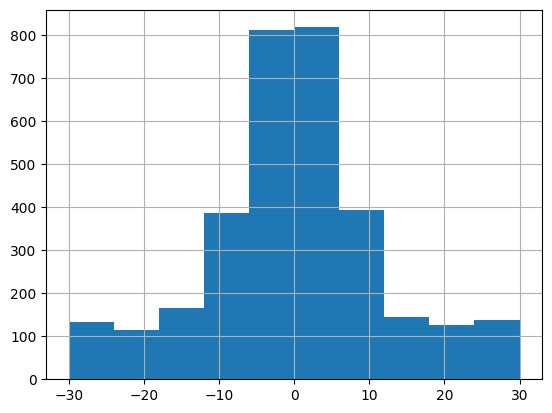

In [24]:
oof_preds[0].hist()

In [25]:
### simple spline, seed(1, 16)~(4, 13)は強制的にfiltaring,  
### seed値に対応して予測スコアも同じ大小関係なら1or0に変換の3モデル
def cal_logloss(pred_vals, y, i):
    y_binary = np.where(y > 0, 1, 0)
    loss = log_loss(y_binary, pred_vals)
    print(f"logloss of cvsplit {i}: {loss:.4f}")


    results.append(f"Normal Spline - logloss of cvsplit {i}: {loss:.4f}")
    return loss

#simple spline
def make_normal_spline(df, y, repeat_cv):
    spline_model1 = []
    logloss_normal = []
    
    for i in range(repeat_cv):
        dat = list(zip(df[i], np.where(y>0, 1, 0)))
        dat = sorted(dat, key=lambda x:x[0])
        datdict = {}
        for k in range(len(dat)):
            datdict[dat[k][0]] = dat[k][1]
        
        spline_model1.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
        spline_fit = spline_model1[i](df[i])
        
        loss = cal_logloss(spline_fit, y, i)    
        logloss_normal.append(loss)

    plot_df = pd.DataFrame({
        "pred": df[0],
        "label": np.where(y>0,1,0),
        "spline": spline_model1[0](df[0])
    })
    plot_df["pred_int"] = plot_df["pred"].astype(int)
    plot_df = plot_df.groupby('pred_int')[['spline','label']].mean().reset_index()
    
    plt.figure(figsize=(8, 5))
    plt.plot(plot_df.pred_int, plot_df.label, marker='o', linestyle='-', label="True Label")
    plt.plot(plot_df.pred_int, plot_df.spline, marker='x', linestyle='--', label="Spline Approximation")
    plt.xlabel("Predicted Value (Integer)")
    plt.ylabel("Mean Value")
    plt.title("Normal Spline Fit Comparison")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(OUTPUT_PATH, f"normal_spline_fit_{PREDICT_YEAR}.png"))
    plt.close()
    
    
    # 例として平均loglossもresultsに記録
    avg_logloss = np.mean(logloss_normal) 
    results.append(f"Average Normal Spline logloss: {avg_logloss:.4f}" if avg_logloss is not None else "No logloss computed")
    
    return spline_model1
            
            
#seed(1, 16)~(4, 13)は強制的にseed通りの結果にフィルタリング
def make_seed1to4_chenge(df, y, repeat_cv):
    spline_model2 = []
    spline_fits = []
    for i in range(repeat_cv):
        dat = list(zip(df[i], np.where(y>0, 1, 0)))
        dat = sorted(dat, key=lambda x:x[0])
        datdict = {}
        for k in range(len(dat)):
            datdict[dat[k][0]] = dat[k][1]
        
        spline_model2.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
        spline_fit = spline_model2[i](df[i]) 
        
        #add
        spline_fit[(X.T1_seed==1) & (X.T2_seed==16)] = 1.0
        spline_fit[(X.T1_seed==2) & (X.T2_seed==15)] = 0.9
        spline_fit[(X.T1_seed==3) & (X.T2_seed==14)] = 0.8
        spline_fit[(X.T1_seed==4) & (X.T2_seed==13)] = 0.7
        spline_fit[(X.T1_seed==16) & (X.T2_seed==1)] = 0.0
        spline_fit[(X.T1_seed==15) & (X.T2_seed==2)] = 0.1
        spline_fit[(X.T1_seed==14) & (X.T2_seed==3)] = 0.2
        spline_fit[(X.T1_seed==13) & (X.T2_seed==4)] = 0.3

    
        cal_logloss(spline_fit, y, i)   
                
        spline_fits.append(spline_fit)
        cal_logloss(spline_fit, y, i)   
                
    
    plot_df = pd.DataFrame({
        "pred": df[0],
        "label": np.where(y > 0, 1, 0),
        "spline": spline_fits[0]  # 変更後の値を利用
    })
    plot_df["pred_int"] = plot_df["pred"].astype(int)
    plot_df = plot_df.groupby("pred_int")[["spline", "label"]].mean().reset_index()

    plt.figure()
    plt.plot(plot_df.pred_int, plot_df.label, label="label")
    plt.plot(plot_df.pred_int, plot_df.spline, label="spline")
    plt.legend()
    plt.show()
    
    return spline_model2
    
    
#完全に値変換するのではなくてseed値に対応して予測スコアも同じ大小関係なら1or0に変換
def make_seed1to4_base_on_score(df, y, repeat_cv):
    spline_model3 = []
    spline_fits = []

    for i in range(repeat_cv):
        dat = list(zip(df[i], np.where(y>0, 1, 0)))
        dat = sorted(dat, key=lambda x:x[0])
        datdict = {}
        for k in range(len(dat)):
            datdict[dat[k][0]] = dat[k][1]
        
        spline_model3.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
        spline_fit = spline_model3[i](df[i]) 
        
        #add
        spline_fit[(X.T1_seed==1) & (X.T2_seed==16) & (X.T1_Score > X.T2_Score)] = 1.0
        spline_fit[(X.T1_seed==2) & (X.T2_seed==15) & (X.T1_Score > X.T2_Score)] = 1.0
        spline_fit[(X.T1_seed==3) & (X.T2_seed==14) & (X.T1_Score > X.T2_Score)] = 1.0
        spline_fit[(X.T1_seed==4) & (X.T2_seed==13) & (X.T1_Score > X.T2_Score)] = 1.0
        spline_fit[(X.T1_seed==16) & (X.T2_seed==1) & (X.T1_Score < X.T2_Score)] = 0.0
        spline_fit[(X.T1_seed==15) & (X.T2_seed==2) & (X.T1_Score < X.T2_Score)] = 0.0
        spline_fit[(X.T1_seed==14) & (X.T2_seed==3) & (X.T1_Score < X.T2_Score)] = 0.0
        spline_fit[(X.T1_seed==13) & (X.T2_seed==4) & (X.T1_Score < X.T2_Score)] = 0.0

        spline_fits.append(spline_fit)
        cal_logloss(spline_fit, y, i)   
    
    
    plot_df = pd.DataFrame({
        "pred": df[0],
        "label": np.where(y > 0, 1, 0),
        "spline": spline_fits[0]  # 変更後の値を利用
    })
    plot_df["pred_int"] = plot_df["pred"].astype(int)
    plot_df = plot_df.groupby("pred_int")[["spline", "label"]].mean().reset_index()

    plt.figure()
    plt.plot(plot_df.pred_int, plot_df.label, label="label")
    plt.plot(plot_df.pred_int, plot_df.spline, label="spline")
    plt.legend()
    plt.show()
    return spline_model3



# Platt Scalingを用いた補正曲線生成の関数 (ロジスティック回帰)
def make_platt_scaling(df, y, repeat_cv):
    platt_models = []
    logloss_platt = []
    
    for i in range(repeat_cv):
        X_train = np.array(df[i]).reshape(-1, 1)
        y_binary = np.where(y > 0, 1, 0)
        
        model = LogisticRegression(random_state=42, solver='lbfgs')
        model.fit(X_train, y_binary)
        platt_models.append(model)
        

        platt_fit = model.predict_proba(X_train)[:, 1]
        loss = cal_logloss(platt_fit, y, i)
        logloss_platt.append(loss)
    
    
    ###
    plot_df = pd.DataFrame({
        "pred": df[0],
        "label": np.where(y > 0, 1, 0),
        "platt": platt_models[0].predict_proba(np.array(df[0]).reshape(-1, 1))[:, 1]
    })
    plot_df["pred_int"] = plot_df["pred"].astype(int)
    plot_df = plot_df.groupby("pred_int")[["platt", "label"]].mean().reset_index()
    
    plt.figure(figsize=(8, 5))
    plt.plot(plot_df.pred_int, plot_df.label, marker='o', linestyle='-', label="True Label")
    plt.plot(plot_df.pred_int, plot_df.platt, marker='x', linestyle='--', label="Platt Scaling")
    plt.xlabel("Predicted Value (Integer)")
    plt.ylabel("Mean Value")
    plt.title("Platt Scaling Calibration Curve")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(OUTPUT_PATH, f"platt_scaling_fit_{PREDICT_YEAR}.png"))
    plt.close()
    
    avg_logloss = np.mean(logloss_platt)
    results.append(f"Average Platt Scaling logloss: {avg_logloss:.4f}" if avg_logloss is not None else "No logloss computed")
    
    return platt_models

def make_isotonic_regression(df, y, repeat_cv):
    """ Isotonic Regression を用いた補正曲線生成 """
    isotonic_models = []
    logloss_isotonic = []
    
    for i in range(repeat_cv):
        X_train = np.array(df[i]).reshape(-1, 1)
        y_binary = np.where(y > 0, 1, 0)
        
        model = IsotonicRegression(out_of_bounds="clip")
        model.fit(X_train.ravel(), y_binary)
        isotonic_models.append(model)
        
        isotonic_fit = model.predict(X_train.ravel())
        loss = cal_logloss(isotonic_fit, y, i)
        logloss_isotonic.append(loss)
    
    plot_df = pd.DataFrame({
        "pred": df[0],
        "label": np.where(y > 0, 1, 0),
        "isotonic": isotonic_models[0].predict(np.array(df[0]).reshape(-1, 1))
    })
    plot_df["pred_int"] = plot_df["pred"].astype(int)
    plot_df = plot_df.groupby("pred_int")[["isotonic", "label"]].mean().reset_index()
    
    plt.figure(figsize=(8, 5))
    plt.plot(plot_df.pred_int, plot_df.label, marker='o', linestyle='-', label="True Label")
    plt.plot(plot_df.pred_int, plot_df.isotonic, marker='x', linestyle='--', label="Isotonic Regression")
    plt.xlabel("Predicted Value (Integer)")
    plt.ylabel("Mean Value")
    plt.title("Isotonic Regression Calibration Curve")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(OUTPUT_PATH, f"isotonic_regression_fit_{PREDICT_YEAR}.png"))
    plt.close()
    
    avg_logloss = np.mean(logloss_isotonic)
    results.append(f"Average Isotonic Regression logloss: {avg_logloss:.4f}" if avg_logloss is not None else "No logloss computed")
    
    return isotonic_models



In [26]:
# キャリブレーションカーブの描画関数
def plot_calibration_curve(y_true, y_pred_proba, method, save_path):
    """ キャリブレーションカーブをプロットし保存 """
    y_binary = np.where(y_true > 0, 1, 0) 
    prob_true, prob_pred = calibration_curve(y_binary, y_pred_proba, n_bins=10)
    
    plt.figure(figsize=(6,6))
    plt.plot(prob_pred, prob_true, marker="o", label=f"{method} Calibration")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect Calibration")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Actual Probability")
    plt.legend()
    plt.title(f"{method} Calibration Curve")
    plt.grid()
    plt.savefig(save_path)
    plt.close()



In [27]:
# キャリブレーション手法の選択
spline = MODEL.spline
if spline == "spline_normal":
    spline_model = make_normal_spline(oof_preds, y, repeat_cv)
    calibrated_preds = spline_model[0](oof_preds[0])
    plot_calibration_curve(y, calibrated_preds, "Spline Normal", os.path.join(OUTPUT_PATH, f"spline_normal_calibration_{PREDICT_YEAR}.png"))
    
elif spline == "logistic":
    spline_model = make_platt_scaling(oof_preds, y, repeat_cv)
    calibrated_preds = spline_model[0].predict_proba(np.array(oof_preds[0]).reshape(-1, 1))[:, 1]
    plot_calibration_curve(y, calibrated_preds, "Platt Scaling", os.path.join(OUTPUT_PATH, f"platt_scaling_calibration_{PREDICT_YEAR}.png"))
    
elif spline == "isotonic":
    spline_model = make_isotonic_regression(oof_preds, y, repeat_cv)
    calibrated_preds = spline_model[0].predict(np.array(oof_preds[0]).reshape(-1, 1))
    plot_calibration_curve(y, calibrated_preds, "Isotonic Regression", os.path.join(OUTPUT_PATH, f"isotonic_regression_calibration_{PREDICT_YEAR}.png"))

logloss of cvsplit 0: 0.5094
logloss of cvsplit 1: 0.5067
logloss of cvsplit 2: 0.5061
logloss of cvsplit 3: 0.5033
logloss of cvsplit 4: 0.5058
logloss of cvsplit 5: 0.5046
logloss of cvsplit 6: 0.5063
logloss of cvsplit 7: 0.5091
logloss of cvsplit 8: 0.5067
logloss of cvsplit 9: 0.5046


# submmit

同じfeature engineeringする.

個々の扱うも考える。2025は最終提出用の関数を用意する、その他2024以前は過去コンペでの提出形式に合わせる、でも年度によって提出形式が変わるからとりあえず2023でやる

In [28]:
"""if PREDICT_YEAR==2022:
    sub = pd.read_csv(os.path.join(INPUT_PATH, "SampleSubmission2022M.csv"))
    sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
    sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
    sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
    sub_X, a = process_tourney(sub, mode = "sub")
    dtest = xgb.DMatrix(sub_X)
elif PREDICT_YEAR==2023:
    sub = pd.read_csv(os.path.join(INPUT_PATH, "SampleSubmission2023.csv"))
    sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
    sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
    sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
    sub_X, a = process_tourney(sub, mode = "sub")
    dtest = xgb.DMatrix(sub_X)
elif PREDICT_YEAR==2024:
    sub = pd.read_csv(os.path.join(INPUT_PATH, "SampleSubmission2024.csv"))
    sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
    sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
    sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
    sub_X, a = process_tourney(sub, mode = "sub")
    dtest = xgb.DMatrix(sub_X)
elif PREDICT_YEAR==2025:
    sub = pd.read_csv(os.path.join(INPUT_PATH, "SampleSubmissionStage2.csv"))
    sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
    sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
    sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))   
    sub_X, a = process_tourney(sub, mode = "sub")
    dtest = xgb.DMatrix(sub_X)"""
    

'if PREDICT_YEAR==2022:\n    sub = pd.read_csv(os.path.join(INPUT_PATH, "SampleSubmission2022M.csv"))\n    sub[\'Season\'] = sub[\'ID\'].apply(lambda x: int(x.split(\'_\')[0]))\n    sub["T1_TeamID"] = sub[\'ID\'].apply(lambda x: int(x.split(\'_\')[1]))\n    sub["T2_TeamID"] = sub[\'ID\'].apply(lambda x: int(x.split(\'_\')[2]))\n    sub_X, a = process_tourney(sub, mode = "sub")\n    dtest = xgb.DMatrix(sub_X)\nelif PREDICT_YEAR==2023:\n    sub = pd.read_csv(os.path.join(INPUT_PATH, "SampleSubmission2023.csv"))\n    sub[\'Season\'] = sub[\'ID\'].apply(lambda x: int(x.split(\'_\')[0]))\n    sub["T1_TeamID"] = sub[\'ID\'].apply(lambda x: int(x.split(\'_\')[1]))\n    sub["T2_TeamID"] = sub[\'ID\'].apply(lambda x: int(x.split(\'_\')[2]))\n    sub_X, a = process_tourney(sub, mode = "sub")\n    dtest = xgb.DMatrix(sub_X)\nelif PREDICT_YEAR==2024:\n    sub = pd.read_csv(os.path.join(INPUT_PATH, "SampleSubmission2024.csv"))\n    sub[\'Season\'] = sub[\'ID\'].apply(lambda x: int(x.split(\'_\')[0]

In [29]:
sub = notexist.copy()
sub = sub.rename(columns={"WTeamID": "T1_TeamID", "LTeamID": "T2_TeamID"})
sub = sub[["Season", "T1_TeamID", "T2_TeamID"]]
temp = sub.copy()
temp = temp.rename(columns={"T1_TeamID": "T2_TeamID", "T2_TeamID": "T1_TeamID"})
sub = pd.concat([sub, temp]).reset_index()
sub_X, a = process_tourney(sub, mode="sub")
sub_X = drop_columns(sub_X, drop_col)
dtest = xgb.DMatrix(sub_X)

no fillna, use nan
drop col list: ['T1_TOmean', 'T2_TOmean', 'T1_opponent_POSS_RATEmean', 'T2_opponent_POSS_RATEmean', 'T1_opponent_Astmean', 'T2_opponent_Astmean', 'T1_opponent_FT_RATEmean', 'T2_opponent_FT_RATEmean', 'T1_opponent_Stlmean', 'T2_opponent_Stlmean', 'T1_ORmean', 'T2_ORmean', 'T1_opponent_ORmean', 'T2_opponent_ORmean', 'T1_TeamID', 'T2_TeamID', 'Season']


In [30]:
sub_models = []
#sokutionではカスタム関数の指定、早期停止の言及がここではなかった。検討する
for i in tqdm(range(repeat_cv), leave=True, dynamic_ncols=True):
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          obj=cauchyobj,
          num_boost_round = int(iteration_counts[i] * 1.05),
          #early_stopping_rounds=early_stopping_rounds, #これ指定してない、指定するのかあと、指定するとしても少し遅くさせるとか
          verbose_eval = 50
        )
    )

  0%|                                                                                                                                                                                                                                      | 0/10 [00:00<?, ?it/s]

 10%|██████████████████████▏                                                                                                                                                                                                       | 1/10 [00:08<01:13,  8.20s/it]

 20%|████████████████████████████████████████████▍                                                                                                                                                                                 | 2/10 [00:15<01:02,  7.83s/it]

 30%|██████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 3/10 [00:23<00:54,  7.85s/it]

 40%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 4/10 [00:32<00:49,  8.22s/it]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 5/10 [00:41<00:43,  8.69s/it]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 6/10 [00:50<00:34,  8.69s/it]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 7/10 [00:59<00:26,  8.70s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 8/10 [01:07<00:17,  8.53s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 9/10 [01:16<00:08,  8.57s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:25<00:00,  8.75s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:25<00:00,  8.54s/it]

各特徴量の寄与度を算出

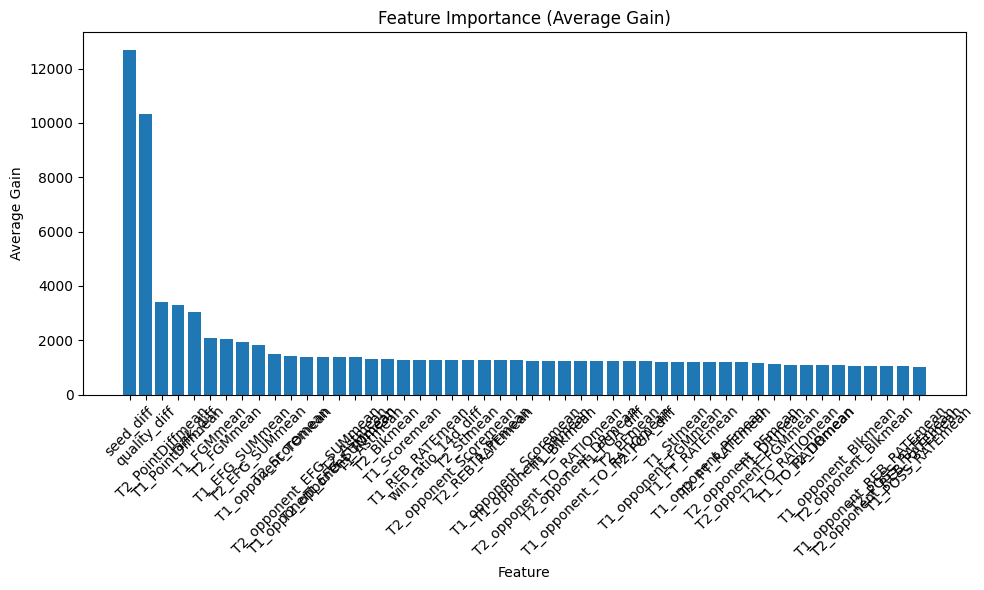

In [31]:
feature_importances = collections.defaultdict(list)
for model in sub_models:
    importance = model.get_score(importance_type='gain')
    for feat, score in importance.items():
        feature_importances[feat].append(score)

avg_importance = {feat: sum(scores) / len(scores) for feat, scores in feature_importances.items()}
fi_df = pd.DataFrame(list(avg_importance.items()), columns=['Feature', 'Avg_Gain'])
fi_df.sort_values(by='Avg_Gain', ascending=False, inplace=True)
results.append("")
fi_log = "-----Feature Importance (Average Gain)-----\n"
for feat, score in fi_df.values:
    fi_log += f"{feat}: {score:.4f}\n"
results.append(fi_log)
results.append("")

plt.figure(figsize=(10, 6))
plt.bar(fi_df['Feature'], fi_df['Avg_Gain'])
plt.xlabel('Feature')
plt.ylabel('Average Gain')
plt.title('Feature Importance (Average Gain)')
plt.xticks(rotation=45)
plt.tight_layout() 

plt.savefig(os.path.join(OUTPUT_PATH, f"feature_importance_{PREDICT_YEAR}.png"))
plt.show()

In [32]:
sub_preds = []
for i in tqdm(range(repeat_cv)):
    if spline == "spline_normal":
        sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest), -30, 30)), 0.025, 0.975))
    
    elif spline == "logistic":
        X_input = np.clip(sub_models[i].predict(dtest), -30, 30).reshape(-1, 1)
        platt_pred = spline_model[i].predict_proba(X_input)[:, 1]
        sub_preds.append(np.clip(platt_pred, 0.025, 0.975))

    elif spline == "isotonic":
        X_input = np.clip(sub_models[i].predict(dtest), -30, 30).reshape(-1, 1)
        iso_pred = spline_model[i].predict(X_input)  # Isotonic Regression の適用
        sub_preds.append(np.clip(iso_pred, 0.025, 0.975))

sub["Pred"] = np.mean(np.vstack(sub_preds), axis=0)

  0%|                                                                                                                                                                                                                                      | 0/10 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 105.23it/s]

In [33]:
# 予測時にテストデータID反転させて予測して平均取る
# dtestの用意とsub_predsの算出を同じようにやる
# sub["Pred"]を反転させたやつとの平均取ったやつにする
TEST_REVERSE = MODEL.test_reverse

if TEST_REVERSE:
    print("----- data flip -----") 
    sub_reverse = notexist.copy()
    sub_reverse = sub_reverse.rename(columns={"WTeamID": "T2_TeamID", "LTeamID": "T1_TeamID"})#reverse!!
    temp_reverse = sub_reverse.copy()
    temp = temp.rename(columns={"T1_TeamID": "T2_TeamID", "T2_TeamID": "T1_TeamID"})
    sub_reverse = pd.concat([sub_reverse, temp_reverse]).reset_index()
    sub_reverse_X, a = process_tourney(sub_reverse, mode="sub")
    sub_reverse_X = drop_columns(sub_reverse_X, drop_col)
    dtest_reverse = xgb.DMatrix(sub_reverse_X)
    
    sub_preds_reverse = []
    for i in tqdm(range(repeat_cv)):
        if spline == "spline_normal":
            sub_preds_reverse.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest_reverse), -30, 30)), 0.025, 0.975))
        
        elif spline == "logistic":
            X_input = np.clip(sub_models[i].predict(dtest_reverse), -30, 30).reshape(-1, 1)
            platt_pred = spline_model[i].predict_proba(X_input)[:, 1]
            sub_preds_reverse.append(np.clip(platt_pred, 0.025, 0.975))

        elif spline == "isotonic":
            X_input = np.clip(sub_models[i].predict(dtest_reverse), -30, 30).reshape(-1, 1)
            iso_pred = spline_model[i].predict(X_input)  # Isotonic Regression の適用
            sub_preds_reverse.append(np.clip(iso_pred, 0.025, 0.975))

    sub_reverse["Pred"] = np.mean(np.vstack(sub_preds_reverse), axis=0)
    
 
    #sub["Pred"]を (sub["Pred"] + (1-sub_reverse["Pred"]))/2に塗り替える(平均取る)
    sub["Pred"] = (sub["Pred"] + (1-sub_reverse["Pred"]))/2


else:
    print("skip data flip")

skip data flip


In [34]:
# teams:64team, targetを受け取って、そのtarget teamの試合可能性のある全63試合を抽出する関数
def extract_target_team_records(submission_df, teams, target_team):
    if target_team not in teams:
        raise ValueError(f"target_team {target_team} は teams 内に存在しません")

    remaining_teams = [t for t in teams if t != target_team]
    
    records = []
    for other_team in remaining_teams:
        lower = min(target_team, other_team)
        higher = max(target_team, other_team)
        row = submission_df[(submission_df['T1_TeamID'] == lower) & (submission_df['T2_TeamID'] == higher)]
        if row.empty:
            print(f"Warning: 対戦 {lower} vs {higher} に対応するレコードが見つかりませんでした")
        else:
            records.append(row)
    
    if records:
        final_records = pd.concat(records, ignore_index=True)
    else:
        final_records = pd.DataFrame()
    
    if len(final_records) != 63:
        print(f"Warning: 期待される63件ではなく、{len(final_records)}件のレコードが抽出されました。")
    
    return final_records


In [35]:
tourney_teams_2023 = [
    1395, 1113,   # TCU1395, アリゾナ・ステイト1113
    1231, 1245,   # インディアナ1231, ケント・ステイト1245
    1243, 1286,   # カンザス・ステイト1243, モンタナ・ステイト1286
    1272, 1194,   # メンフィス1272, ﾌﾛﾘﾀﾞ･ｱﾄﾗﾝﾃｨｯｸ1194
    1211, 1213,   # ゴンザガ1211, グランド・キャニオン1213
    1274, 1179,   # マイアミ（フロリダ）1274, ドレイク1179
    1243, 1286,   # ケンタッキー1243, プロビデンス1286
    1345, 1192,   # パデュー1345, ﾌｪｱﾘｰ･ﾃﾞｨｷﾝｿﾝ1192
    1163, 1233,   # コネチカット1163, アイオナ1233
    1166, 1301,   # クレイトン1166, ﾉｰｽｶﾛﾗｲﾅ･ｽﾃｲﾄ1301
    1235, 1338,   # アイオワ・ステイト1235, ピッツバーグ1338
    1266, 1436,   # マーケット1266, バーモント1436
    1388, 1433,   # ｾﾝﾄﾒｱﾘｰｽﾞ（ｶﾘﾌｫﾙﾆｱ）1388, VCU1433
    1124, 1364,   # ベイラー1124, UCサンタバーバラ1364
    1462, 1244,   # ザビエル1462, ケネソー・ステイト1244
    1277, 1425,   # ミシガン・ステイト1277, USC トロージャンズ1425

    1417, 1421,   # UCLA1417, UNC アシュビル1421
    1401, 1336,   # テキサス A＆M1401, ﾍﾟﾝｼﾞﾙﾍﾞﾆｱ･ｽﾃｲﾄ1336
    1397, 1418,   # テネシー1397, ﾙｲｼﾞｱﾅ･ﾗﾌｧｲｴｯﾄ1418
    1222, 1297,   # ヒューストン1222, ノーザンケンタッキー1297
    1321, 1129,   # ノースウェスタン1321, ボイシ・ステイト1129
    1400, 1159,   # テキサス1400, コルゲート1159
    1181, 1331,   # デューク1181, オーラル・ロバーツ1331
    1234, 1120,   # アイオワ1234, オーバーン1120
    1116, 1228,   # アーカンソー1116, イリノイ1228
    1112, 1343,   # アリゾナ1112, プリンストン1343
    1361, 1158,   # ｻﾝﾃﾞｴｺﾞ･ｽﾃｲﾄ1361, チャールストン1158
    1104, 1394,   # アラバマ1104, テキサス A＆M CC1394
    1242, 1224,   # カンザス1242, ハワード1224
    1281, 1429,   # ミズーリ1281, ユタ・ステイト1429
    1438, 1202,   # バージニア1438, ファーマン1202
    1268, 1452    # メリーランド1268, ウェストバージニア1452
]

#Connecticut_vs = extract_target_team_records(sub, tourney_teams_2023, 1163 )

In [36]:
#handlabelingを行う関数
def make_handlabeling(df, season, T1, T2, labeling_pred, tourney_teams):
    if T1 not in tourney_teams or T2 not in tourney_teams: 
        print(f"トーナメント対象チームに属していません")
        return 
    
    if T1>T2: 
        T1, T2 = T2, T1
        print(f"{T1}, {T2}ID逆だけど大丈夫？？")
    id = f"{season}_{T1}_{T2}"

    print(f"before: {df[df['ID']==id]}")
    df.loc[df["ID"] == id, "Pred"] = labeling_pred
    print(f"after: {df[df['ID']==id]}")
    
    results.append(f"-----handolabeling-----")
    results.append(f"before:  {df[df['ID']==id]} -----> after: {df[df['ID']==id]}")
    results.appedn("")
    return df

In [37]:
labeling = cfg.exp.hand_labeling
if labeling is not None:
    for i in range(len(labeling)):
        T1 = labeling[i][0]
        T2 = labeling[i][1]
        labeling_pred = labeling[i][2]
        
        print(f"{T1} vs {T2} result labeling {labeling_pred}")
        
        sub = make_handlabeling(sub, PREDICT_YEAR, T1, T2, labeling_pred, tourney_teams_2023)

Tournament matchups only - Pred Mean: 0.5000953046324943


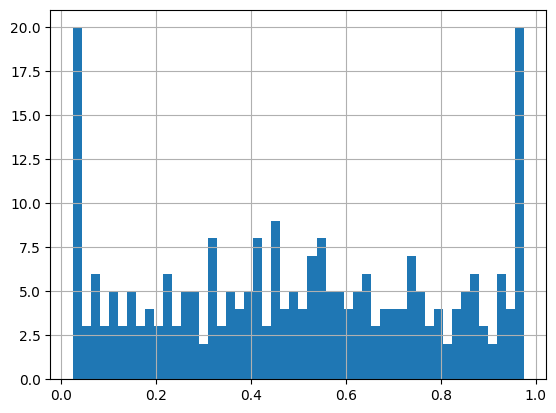

In [38]:
tourney_filtered = notexist[notexist["Season"] == PREDICT_YEAR].copy()
a = tourney_filtered.rename(columns={'WTeamID': 'T1_TeamID', 'LTeamID': 'T2_TeamID'})
b = tourney_filtered.rename(columns={'WTeamID': 'T2_TeamID', 'LTeamID': 'T1_TeamID'})
ab = pd.concat([a, b]).reset_index(drop=True) 
filtered_sub = sub.merge(ab[['Season', 'T1_TeamID', 'T2_TeamID']], 
                         on=['Season', 'T1_TeamID', 'T2_TeamID'], 
                         how='inner')

filtered_sub["Pred"].astype(int)
pred_mean = filtered_sub["Pred"].mean()
print("Tournament matchups only - Pred Mean:", pred_mean)

filtered_sub["Pred"].hist(bins=50)
results+=["", f"Tournament matchups only - Pred Mean:, {pred_mean}", ""]
plt.figure(figsize=(8, 6))
filtered_sub["Pred"].hist(bins=50)
plt.title("Prediction Histogram")
plt.xlabel("Pred")
plt.ylabel("Frequency")
plt.grid(True)

# 画像として保存
plt.savefig(os.path.join(OUTPUT_PATH, f"Prediction_Histgram_filtered_{PREDICT_YEAR}.png"))
plt.close()

# スコア算出、まとめ、
ここまでで提出ファイル作成。ここからは過去年度のシミュレーションに対してBrier scoreやその他指標の算出

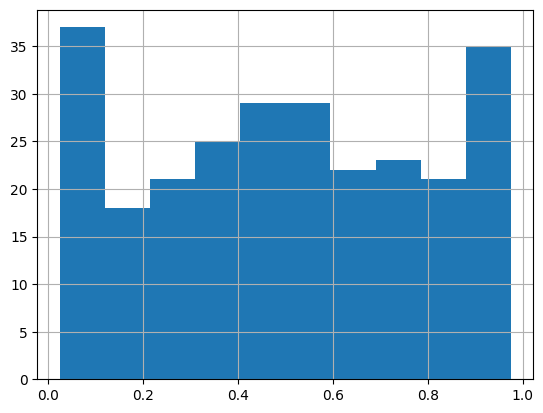

In [39]:
sub["Pred"].hist()
results+=["", f"Pred mean: {sub['Pred'].mean()}", ""]

plt.figure(figsize=(8, 6))
sub["Pred"].hist(bins=50)
plt.title("Prediction Histogram")
plt.xlabel("Pred")
plt.ylabel("Frequency")
plt.grid(True)

# 画像として保存
plt.savefig(os.path.join(OUTPUT_PATH, f"Prediction_Histgram_{PREDICT_YEAR}.png"))
plt.close()

存在するはずのない予測年度のトーナメント結果をもとに(Pred, label)を取り出し、以下を行う。

- 各評価指標の計算
- キャリブレーション可視化
- AUC可視化

In [40]:
def extract_labels_and_preds(sub, tourney):
    """ 試合データから予測値 (Pred) と正解ラベル (label) を抽出する """
    label_data = tourney[["WTeamID", "LTeamID", "WScore", "LScore"]]
    label_data = label_data.rename(columns={"WTeamID": "T1_TeamID", "LTeamID": "T2_TeamID", "WScore": "T1_Score", "LScore": "T2_Score"})
    temp = label_data.copy()
    temp = temp.rename(columns={"T1_TeamID": "T2_TeamID", "T2_TeamID": "T1_TeamID", "T1_Score": "T2_Score", "T2_Score": "T1_Score"})
    label_data = pd.concat([label_data, temp]).reset_index(drop=True)
    
    label_data = pd.merge(label_data, sub, on=["T1_TeamID", "T2_TeamID"], how="left")
    label_data["label"] = np.where(label_data["T1_Score"] - label_data["T2_Score"] > 0, 1, 0)
    label_data = label_data.dropna(subset=["Pred"])  # 欠損値を削除
    
    return label_data[["label", "Pred"]]

def calculate_metrics(label_data):
    """ 各評価指標を計算 """
    brier_score = round(mean_squared_error(label_data["label"], label_data["Pred"]), 5)  # Brier Score (MSEと同じ)
    rmse_score = round(mean_squared_error(label_data["label"], label_data["Pred"], squared=False), 5)  # RMSE
    logloss_score = round(log_loss(label_data["label"], label_data["Pred"]), 5)  # Log Loss
    mae_score = round(mean_absolute_error(label_data["label"], label_data["Pred"]), 5)  # MAE
    
    return {
        "Brier Score": brier_score,
        "RMSE": rmse_score,
        "Log Loss": logloss_score,
        "MAE": mae_score
    }

def plot_calibration_curve(label_data, n_bins=10):
    """ キャリブレーションカーブをプロット """
    prob_true, prob_pred = calibration_curve(label_data["label"], label_data["Pred"], n_bins=n_bins)
    
    plt.figure(figsize=(6,6))
    plt.plot(prob_pred, prob_true, marker="o", label="Model Calibration")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect Calibration")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Actual Probability")
    plt.legend()
    plt.title("Calibration Curve")
    plt.show()

def calculate_auc_metrics(label_data):
    global results
    """ AUC-ROCとAUC-PRを計算 """
    auc_roc = roc_auc_score(label_data["label"], label_data["Pred"])
    auc_pr = average_precision_score(label_data["label"], label_data["Pred"])
    
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"AUC-PR: {auc_pr:.4f}")
    results += ["---- AUC -----", f"AUC-ROC: {auc_roc:.4f}", f"AUC-PR: {auc_pr:.4f}"]
    

C:\Users\81809\anaconda3\envs\deep_learning_pytorch\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


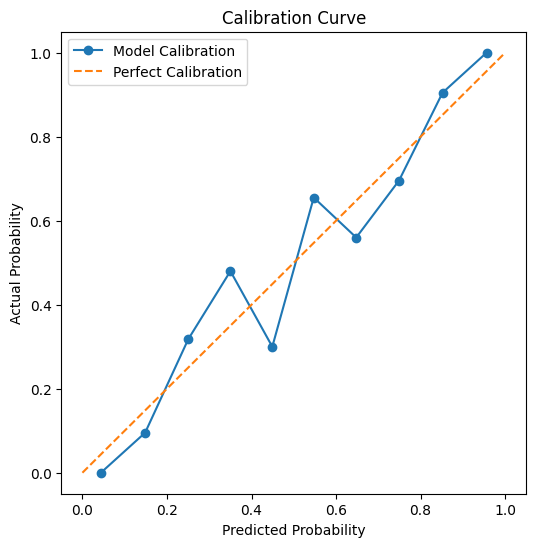

AUC-ROC: 0.8543
AUC-PR: 0.8663
MAE: 0.31706

---- AUC -----
AUC-ROC: 0.8543
AUC-PR: 0.8663


In [41]:
if PREDICT_YEAR == 2022:
    notexist_MAN = notexist[notexist["WTeamID"].astype(str).str.startswith("1")]
    notexist_WOMAN = notexist[notexist["WTeamID"].astype(str).str.startswith("3")]
    label_data = extract_labels_and_preds(sub, notexist) ######
else:
    label_data = extract_labels_and_preds(sub, notexist)

# 評価指標の計算
score = calculate_metrics(label_data)
results += ["","-----eval metrics-----",
            f"Brier Score: {score['Brier Score']}", 
            f"RMSE: {score['RMSE']}", 
            f"Log Loss: {score['Log Loss']}", 
            f"MAE: {score['MAE']}", ""]

# キャリブレーションの確認
plot_calibration_curve(label_data)

# AUCの評価
calculate_auc_metrics(label_data)

for temp in range(-5, 0):
    print(results[temp])

In [42]:
"""if PREDICT_YEAR!=2025:
    predict_year_label =notexist[["WTeamID", "LTeamID", "WScore", "LScore"]].copy()
    predict_year_label.loc[:, "Win"] = np.where(predict_year_label["WScore"] - predict_year_label["LScore"] > 0, 1, 0)
    predict_year_label = predict_year_label[["WTeamID", "LTeamID", "Win"]]
   
    predict_year_label.columns = ["T1_TeamID", "T2_TeamID", "Win"]

    predict_year_label = pd.merge(predict_year_label, sub, on=["T1_TeamID", "T2_TeamID"], how="left")
    brier_score = np.mean((predict_year_label["Pred"] - predict_year_label["Win"])**2)

    print("Brier Score:", brier_score)
    results+=[f"Brier Score: {brier_score}", ""]
    predict_year_label.info()
"""

'if PREDICT_YEAR!=2025:\n    predict_year_label =notexist[["WTeamID", "LTeamID", "WScore", "LScore"]].copy()\n    predict_year_label.loc[:, "Win"] = np.where(predict_year_label["WScore"] - predict_year_label["LScore"] > 0, 1, 0)\n    predict_year_label = predict_year_label[["WTeamID", "LTeamID", "Win"]]\n   \n    predict_year_label.columns = ["T1_TeamID", "T2_TeamID", "Win"]\n\n    predict_year_label = pd.merge(predict_year_label, sub, on=["T1_TeamID", "T2_TeamID"], how="left")\n    brier_score = np.mean((predict_year_label["Pred"] - predict_year_label["Win"])**2)\n\n    print("Brier Score:", brier_score)\n    results+=[f"Brier Score: {brier_score}", ""]\n    predict_year_label.info()\n'

In [43]:
END_TIME = time.time()
ELAPSED_TIME = END_TIME - START_TIME
print(f"実行時間： {ELAPSED_TIME:.1f}秒")
results.append(f"実行時間： {ELAPSED_TIME:.1f}秒")

with open(os.path.join(OUTPUT_PATH, "result.txt"), "a", encoding="utf-8") as f:
    for line in results:
        f.write(line + "\n")

実行時間： 886.1秒


In [44]:
logger.remove()